In [2]:
import numpy as np
import glob
import os
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [9]:
# 분산 전략 설정: GPU 수에 따라 설정
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) >= 1:
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])  # GPU 디바이스 번호에 맞게 수정
    print(f'사용 중인 디바이스 수: {strategy.num_replicas_in_sync}')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'기본 전략 사용 중: {strategy.num_replicas_in_sync}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
사용 중인 디바이스 수: 2


### all landmark

In [4]:
# 메모리 매핑을 사용하여 데이터 로드
images = np.load('f_youtube_dataset_images.npy', mmap_mode='r')
landmarks = np.load('f_youtube_dataset_landmarks.npy', mmap_mode='r')

# 50,000개 샘플로 제한
limit = 50000
images_subset = images[:limit]
landmarks_subset = landmarks[:limit]

# 서브셋의 형태 출력
print(f'제한된 이미지 형태: {images_subset.shape}')         # 예: (limit, 224, 224, 3)
print(f'제한된 키포인트 형태: {landmarks_subset.shape}')   # 예: (limit, 68, 2)

제한된 이미지 형태: (50000, 224, 224, 3)
제한된 키포인트 형태: (50000, 68, 2)


데이터셋 셔플, 배치, 프리페치 설정 완료.
배치 이미지 형태: (48, 224, 224, 3)
배치 키포인트 형태: (48, 136)


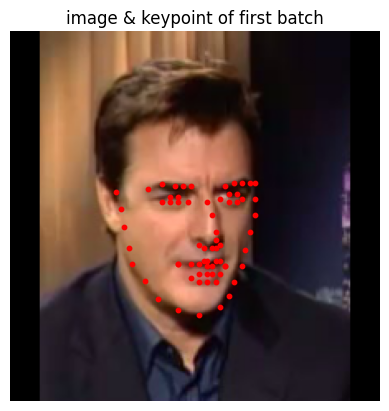

In [5]:
# 제너레이터 함수 정의 (개별 샘플 반환)
def data_generator(images, landmarks):
    num_samples = images.shape[0]
    indices = np.arange(num_samples)
    np.random.shuffle(indices)  # 샘플 섞기

    for idx in indices:
        image = images[idx].astype(np.float32) / 255.0  # 이미지 정규화 [0,1]
        landmark = landmarks[idx].astype(np.float32) / 224.0  # 키포인트 정규화 [0,1]
        landmark = landmark.reshape(-1)  # (68, 2) -> (136,)
        yield image, landmark

def generator():
    return data_generator(images, landmarks)

# TensorFlow 데이터셋 생성 (개별 샘플 반환)
output_signature = (
    tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(136,), dtype=tf.float32)
)

dataset = tf.data.Dataset.from_generator(
    generator,
    output_signature=output_signature
)

# 데이터셋 셔플, 배치, 프리페치 설정
batch_size_per_replica = 16  # 각 GPU당 배치 사이즈
batch_size = batch_size_per_replica * strategy.num_replicas_in_sync  # 전체 배치 크기

dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

print('데이터셋 셔플, 배치, 프리페치 설정 완료.')

# 데이터셋 형태 확인 및 시각화
for batch_images, batch_landmarks in dataset.take(1):
    print('배치 이미지 형태:', batch_images.shape)         # (, 224, 224, 3)
    print('배치 키포인트 형태:', batch_landmarks.shape)   # (, 136)
    
    # 시각화 예시
    image = batch_images[0].numpy()
    landmarks_plot = batch_landmarks[0].numpy() * 224.0  # 정규화된 키포인트를 원래 크기로 복원

    plt.imshow(image)
    plt.scatter(landmarks_plot[::2], landmarks_plot[1::2], c='r', s=10)
    plt.title('image & keypoint of first batch')
    plt.axis('off')
    plt.show()

In [6]:
# 학습용과 검증용 데이터셋 분리
total_samples = 50000
train_ratio = 0.8
val_ratio = 0.2

train_size = int(train_ratio * total_samples)  
val_size = total_samples - train_size        

train_ds = dataset.take(train_size // batch_size)  
val_ds = dataset.skip(train_size // batch_size).take(val_size // batch_size)  

print(f'학습 데이터셋 배치 수: {train_size // batch_size}')  
print(f'검증 데이터셋 배치 수: {val_size // batch_size}')  

학습 데이터셋 배치 수: 833
검증 데이터셋 배치 수: 208


In [7]:
# 분산 전략 설정: GPU 수에 맞게 설정 (현재는 1개)
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) >= 1:
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:2"])
    print(f'사용 중인 디바이스 수: {strategy.num_replicas_in_sync}')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'기본 전략 사용 중: {strategy.num_replicas_in_sync}')

# 분산 전략 내에서 모델 정의 및 컴파일
with strategy.scope():
    def create_model(input_shape=(224, 224, 3), num_keypoints=68*2):
        base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
        base_model.trainable = True  # 전이 학습을 위해 백본 고정

        x = base_model.output
        x = layers.BatchNormalization()(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(1024, activation='relu')(x)
        outputs = layers.Dense(num_keypoints)(x)  # 회귀 문제이므로 활성화 함수 없음

        model = models.Model(inputs=base_model.input, outputs=outputs)
        return model

    # 모델 정의
    model = create_model()

    # 모델 컴파일
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='mean_squared_error',
                  metrics=['mae'])

    # 모델 요약
    model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:2')
사용 중인 디바이스 수: 2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0

In [9]:
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint, CSVLogger
import time

def lr_scheduler(epoch):
    if epoch < 50:
        return 0.001  # 첫 50 에포크 동안 학습률은 0.001
    else:
        return 0.0001  # 에포크 51부터 100까지 학습률은 0.0001

# 에포크 시간 측정을 위한 콜백 클래스 정의
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()
        
# 콜백 설정
checkpoint = ModelCheckpoint('y_all_v2_adam.h5', monitor='val_loss', save_best_only=True, verbose=1)
# lr_scheduler_callback = LearningRateScheduler(lr_scheduler)
time_callback = TimeHistory()
csv_logger = CSVLogger('y_all_training_log.csv', append=True)

# **모델 훈련**

EPOCHS = 100

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint, time_callback, csv_logger]
)

Epoch 1/100
INFO:tensorflow:Collective all_reduce tensors: 162 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 162 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2024-11-12 03:10:57.632354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5102 of 50000
2024-11-12 03:11:07.632613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9859 of 50000
2024-11-12 03:11:27.632310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18341 of 50000
2024-11-12 03:11:37.633033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23186 of 50000
2024-11-12 03:11:57.700142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 32741 of 50000
2024-11-12 03:12:17.633658: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

   1250/Unknown - 306s 114ms/step - loss: 0.0122 - mae: 0.0639

2024-11-12 03:15:17.676225: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3389129875074278628
2024-11-12 03:15:17.676302: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4040788936358420590
2024-11-12 03:15:17.676345: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7356975621126152926
2024-11-12 03:15:17.676357: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11842050104980683464
2024-11-12 03:15:17.676373: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7008260526685799650
2024-11-12 03:15:17.676384: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7007174390449191568
2024-11-12 03:15:17.676396: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it


Epoch 1: val_loss improved from inf to 0.00774, saving model to y_all_v2_adam.h5


2024-11-12 03:19:29.847259: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4748243619971525924
2024-11-12 03:19:29.847341: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13360921775609734008
2024-11-12 03:19:29.847360: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1038487052206384256
2024-11-12 03:19:29.847375: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15345452256229672804
2024-11-12 03:19:29.847392: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4040788936358420590
2024-11-12 03:19:29.847466: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11990925725729335732
2024-11-12 03:19:29.847488: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv 

1250/1250 [==============================] - 560s 317ms/step - loss: 0.0122 - mae: 0.0639 - val_loss: 0.0077 - val_mae: 0.0706
Epoch 2/100


2024-11-12 03:19:41.656600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3417 of 50000
2024-11-12 03:19:51.659612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6311 of 50000
2024-11-12 03:20:11.657755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 15224 of 50000
2024-11-12 03:20:31.657451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24100 of 50000
2024-11-12 03:20:51.656616: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 32574 of 50000
2024-11-12 03:21:11.663730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 8.2737e-04 - mae: 0.0222

2024-11-12 03:24:05.062929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3821 of 50000
2024-11-12 03:24:15.098284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8249 of 50000
2024-11-12 03:24:25.123120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 11691 of 50000
2024-11-12 03:24:45.064722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18749 of 50000
2024-11-12 03:25:05.063060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26681 of 50000
2024-11-12 03:25:15.066840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 2: val_loss improved from 0.00774 to 0.00208, saving model to y_all_v2_adam.h5
1250/1250 [==============================] - 530s 326ms/step - loss: 8.2737e-04 - mae: 0.0222 - val_loss: 0.0021 - val_mae: 0.0375
Epoch 3/100


2024-11-12 03:28:31.915511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4769 of 50000
2024-11-12 03:28:51.915107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14394 of 50000
2024-11-12 03:29:11.912266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23447 of 50000
2024-11-12 03:29:21.918399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 27866 of 50000
2024-11-12 03:29:41.915068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 36015 of 50000
2024-11-12 03:30:01.933160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 4.3683e-04 - mae: 0.0162

2024-11-12 03:32:48.072976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4378 of 50000
2024-11-12 03:33:08.070985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12969 of 50000
2024-11-12 03:33:18.073473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17254 of 50000
2024-11-12 03:33:28.088381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21292 of 50000
2024-11-12 03:33:48.072501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 27544 of 50000
2024-11-12 03:34:08.081920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 3: val_loss improved from 0.00208 to 0.00103, saving model to y_all_v2_adam.h5
1250/1250 [==============================] - 550s 348ms/step - loss: 4.3683e-04 - mae: 0.0162 - val_loss: 0.0010 - val_mae: 0.0257
Epoch 4/100


2024-11-12 03:37:42.596136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4251 of 50000
2024-11-12 03:38:02.593565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12839 of 50000
2024-11-12 03:38:22.594437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21438 of 50000
2024-11-12 03:38:32.595028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25915 of 50000
2024-11-12 03:38:52.595439: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 32673 of 50000
2024-11-12 03:39:12.594784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 3.0347e-04 - mae: 0.0135

2024-11-12 03:42:16.248646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4743 of 50000
2024-11-12 03:42:36.248910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13851 of 50000
2024-11-12 03:42:56.248690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22577 of 50000
2024-11-12 03:43:06.262917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26372 of 50000
2024-11-12 03:43:26.253490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 32825 of 50000
2024-11-12 03:43:46.247545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 4: val_loss improved from 0.00103 to 0.00044, saving model to y_all_v2_adam.h5
1250/1250 [==============================] - 541s 331ms/step - loss: 3.0347e-04 - mae: 0.0135 - val_loss: 4.4381e-04 - val_mae: 0.0165
Epoch 5/100


2024-11-12 03:46:44.199093: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4092 of 50000
2024-11-12 03:46:54.212805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7202 of 50000
2024-11-12 03:47:14.199388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 15124 of 50000
2024-11-12 03:47:34.245338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22752 of 50000
2024-11-12 03:47:54.198933: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 29755 of 50000
2024-11-12 03:48:04.200891: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 2.4549e-04 - mae: 0.0121

2024-11-12 03:51:18.045430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4008 of 50000
2024-11-12 03:51:28.046071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8241 of 50000
2024-11-12 03:51:48.049380: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17172 of 50000
2024-11-12 03:52:08.053259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24510 of 50000
2024-11-12 03:52:28.045516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 32935 of 50000
2024-11-12 03:52:48.045617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 5: val_loss did not improve from 0.00044
1250/1250 [==============================] - 543s 329ms/step - loss: 2.4549e-04 - mae: 0.0121 - val_loss: 4.8927e-04 - val_mae: 0.0171
Epoch 6/100


2024-11-12 03:55:47.228997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4365 of 50000
2024-11-12 03:56:07.226262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12954 of 50000
2024-11-12 03:56:27.228658: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20784 of 50000
2024-11-12 03:56:47.274251: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 27948 of 50000
2024-11-12 03:57:07.226092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 35580 of 50000
2024-11-12 03:57:17.228084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 2.0023e-04 - mae: 0.0109

2024-11-12 04:00:20.029421: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3942 of 50000
2024-11-12 04:00:30.029606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8389 of 50000
2024-11-12 04:00:40.037727: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13073 of 50000
2024-11-12 04:01:00.028703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20552 of 50000
2024-11-12 04:01:10.029692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24486 of 50000
2024-11-12 04:01:20.031504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 6: val_loss improved from 0.00044 to 0.00037, saving model to y_all_v2_adam.h5
1250/1250 [==============================] - 540s 330ms/step - loss: 2.0023e-04 - mae: 0.0109 - val_loss: 3.6522e-04 - val_mae: 0.0148
Epoch 7/100


2024-11-12 04:04:47.308970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4681 of 50000
2024-11-12 04:04:57.311362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9473 of 50000
2024-11-12 04:05:17.309684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17629 of 50000
2024-11-12 04:05:27.310915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21331 of 50000
2024-11-12 04:05:47.308196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 28820 of 50000
2024-11-12 04:05:57.309333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 1.7745e-04 - mae: 0.0103

2024-11-12 04:09:17.730143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4590 of 50000
2024-11-12 04:09:27.731068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9003 of 50000
2024-11-12 04:09:47.730459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 16256 of 50000
2024-11-12 04:09:57.838498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 19981 of 50000
2024-11-12 04:10:17.731705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26939 of 50000
2024-11-12 04:10:37.729894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 7: val_loss did not improve from 0.00037
1250/1250 [==============================] - 547s 333ms/step - loss: 1.7745e-04 - mae: 0.0103 - val_loss: 7.6197e-04 - val_mae: 0.0217
Epoch 8/100


2024-11-12 04:13:54.082699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4682 of 50000
2024-11-12 04:14:04.084255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8718 of 50000
2024-11-12 04:14:24.116125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 16530 of 50000
2024-11-12 04:14:44.092770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24509 of 50000
2024-11-12 04:15:04.082833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 32414 of 50000
2024-11-12 04:15:24.082328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 1.5392e-04 - mae: 0.0095

2024-11-12 04:18:18.022111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4762 of 50000
2024-11-12 04:18:28.023418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8650 of 50000
2024-11-12 04:18:38.066856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12401 of 50000
2024-11-12 04:18:48.102772: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 16154 of 50000
2024-11-12 04:19:08.022593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23687 of 50000
2024-11-12 04:19:18.024257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 8: val_loss improved from 0.00037 to 0.00021, saving model to y_all_v2_adam.h5
1250/1250 [==============================] - 548s 340ms/step - loss: 1.5392e-04 - mae: 0.0095 - val_loss: 2.0733e-04 - val_mae: 0.0113
Epoch 9/100


2024-11-12 04:23:02.686110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3820 of 50000
2024-11-12 04:23:12.766564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7742 of 50000
2024-11-12 04:23:32.686708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 16055 of 50000
2024-11-12 04:23:42.746297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20343 of 50000
2024-11-12 04:24:02.686970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 28824 of 50000
2024-11-12 04:24:12.688236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 1.3862e-04 - mae: 0.0090

2024-11-12 04:27:30.991429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3852 of 50000
2024-11-12 04:27:40.991528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7835 of 50000
2024-11-12 04:27:50.994066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12023 of 50000
2024-11-12 04:28:01.048653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 15985 of 50000
2024-11-12 04:28:20.993856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24320 of 50000
2024-11-12 04:28:31.003031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 9: val_loss did not improve from 0.00021
1250/1250 [==============================] - 538s 333ms/step - loss: 1.3862e-04 - mae: 0.0090 - val_loss: 2.7396e-04 - val_mae: 0.0129
Epoch 10/100


2024-11-12 04:32:01.003607: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3811 of 50000
2024-11-12 04:32:21.000658: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 11360 of 50000
2024-11-12 04:32:41.000260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18993 of 50000
2024-11-12 04:32:51.013762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22091 of 50000
2024-11-12 04:33:11.003664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 29731 of 50000
2024-11-12 04:33:31.000414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 1.2728e-04 - mae: 0.0086

2024-11-12 04:36:29.653854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3996 of 50000
2024-11-12 04:36:49.653348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12314 of 50000
2024-11-12 04:37:09.653175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21108 of 50000
2024-11-12 04:37:29.651544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 29145 of 50000
2024-11-12 04:37:39.652842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 33111 of 50000
2024-11-12 04:37:49.715007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 10: val_loss did not improve from 0.00021
1250/1250 [==============================] - 550s 337ms/step - loss: 1.2728e-04 - mae: 0.0086 - val_loss: 4.4698e-04 - val_mae: 0.0165
Epoch 11/100


2024-11-12 04:41:22.937347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4267 of 50000
2024-11-12 04:41:42.942378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12989 of 50000
2024-11-12 04:42:02.934262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21290 of 50000
2024-11-12 04:42:12.934405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25240 of 50000
2024-11-12 04:42:22.984222: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 29164 of 50000
2024-11-12 04:42:42.934169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 1.1615e-04 - mae: 0.0082

2024-11-12 04:45:50.871798: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3914 of 50000
2024-11-12 04:46:00.872139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6997 of 50000
2024-11-12 04:46:10.882616: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 11167 of 50000
2024-11-12 04:46:30.875016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20026 of 50000
2024-11-12 04:46:40.972153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24485 of 50000
2024-11-12 04:47:00.872552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 11: val_loss did not improve from 0.00021
1250/1250 [==============================] - 551s 340ms/step - loss: 1.1615e-04 - mae: 0.0082 - val_loss: 5.4133e-04 - val_mae: 0.0192
Epoch 12/100


2024-11-12 04:50:34.157991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4748 of 50000
2024-11-12 04:50:44.158356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8807 of 50000
2024-11-12 04:50:54.158573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13061 of 50000
2024-11-12 04:51:14.157904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21709 of 50000
2024-11-12 04:51:24.170057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25965 of 50000
2024-11-12 04:51:44.157487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 1.0509e-04 - mae: 0.0079

2024-11-12 04:55:09.913157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3664 of 50000
2024-11-12 04:55:29.903596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 11603 of 50000
2024-11-12 04:55:39.905846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 15480 of 50000
2024-11-12 04:55:49.906904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 19314 of 50000
2024-11-12 04:56:09.904551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 27416 of 50000
2024-11-12 04:56:19.905324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 12: val_loss did not improve from 0.00021
1250/1250 [==============================] - 567s 345ms/step - loss: 1.0509e-04 - mae: 0.0079 - val_loss: 5.0820e-04 - val_mae: 0.0190
Epoch 13/100


2024-11-12 05:00:01.027057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4524 of 50000
2024-11-12 05:00:11.027734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9036 of 50000
2024-11-12 05:00:31.029605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17954 of 50000
2024-11-12 05:00:51.024765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26441 of 50000
2024-11-12 05:01:01.025149: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 30366 of 50000
2024-11-12 05:01:21.023022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 1.0072e-04 - mae: 0.0076

2024-11-12 05:04:31.062399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3955 of 50000
2024-11-12 05:04:51.060681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 11717 of 50000
2024-11-12 05:05:01.062971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 15588 of 50000
2024-11-12 05:05:11.152087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 19421 of 50000
2024-11-12 05:05:31.082286: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25362 of 50000
2024-11-12 05:05:51.086028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 13: val_loss did not improve from 0.00021
1250/1250 [==============================] - 563s 354ms/step - loss: 1.0072e-04 - mae: 0.0076 - val_loss: 2.7108e-04 - val_mae: 0.0133
Epoch 14/100


2024-11-12 05:09:24.116407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4231 of 50000
2024-11-12 05:09:44.020688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12917 of 50000
2024-11-12 05:09:54.020824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 16869 of 50000
2024-11-12 05:10:04.028649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20991 of 50000
2024-11-12 05:10:24.048019: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 29121 of 50000
2024-11-12 05:10:44.026561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 9.6288e-05 - mae: 0.0075

2024-11-12 05:13:59.790952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4461 of 50000
2024-11-12 05:14:09.792706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8664 of 50000
2024-11-12 05:14:19.804634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12617 of 50000
2024-11-12 05:14:39.798245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20850 of 50000
2024-11-12 05:14:59.791266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 28411 of 50000
2024-11-12 05:15:09.791985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 14: val_loss improved from 0.00021 to 0.00017, saving model to y_all_v2_adam.h5
1250/1250 [==============================] - 571s 356ms/step - loss: 9.6288e-05 - mae: 0.0075 - val_loss: 1.6828e-04 - val_mae: 0.0102
Epoch 15/100


2024-11-12 05:18:55.226981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4457 of 50000
2024-11-12 05:19:05.227673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8897 of 50000
2024-11-12 05:19:15.282484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12165 of 50000
2024-11-12 05:19:35.226857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17745 of 50000
2024-11-12 05:19:45.227232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21049 of 50000
2024-11-12 05:19:55.228697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 9.2864e-05 - mae: 0.0074

2024-11-12 05:23:30.473416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4428 of 50000
2024-11-12 05:23:50.472812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13027 of 50000
2024-11-12 05:24:10.472883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21357 of 50000
2024-11-12 05:24:30.471564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 29156 of 50000
2024-11-12 05:24:40.472301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 32696 of 50000
2024-11-12 05:24:50.474662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 15: val_loss did not improve from 0.00017
1250/1250 [==============================] - 559s 339ms/step - loss: 9.2864e-05 - mae: 0.0074 - val_loss: 2.0833e-04 - val_mae: 0.0111
Epoch 16/100


2024-11-12 05:28:14.062795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3786 of 50000
2024-11-12 05:28:24.063730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7859 of 50000
2024-11-12 05:28:44.064683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 16375 of 50000
2024-11-12 05:29:04.064637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24974 of 50000
2024-11-12 05:29:14.073448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 28909 of 50000
2024-11-12 05:29:34.063765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 9.1660e-05 - mae: 0.0073

2024-11-12 05:32:43.348942: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4420 of 50000
2024-11-12 05:32:53.352656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9042 of 50000
2024-11-12 05:33:13.344731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17962 of 50000
2024-11-12 05:33:23.346940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22121 of 50000
2024-11-12 05:33:33.347341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26091 of 50000
2024-11-12 05:33:53.344481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 16: val_loss improved from 0.00017 to 0.00014, saving model to y_all_v2_adam.h5
1250/1250 [==============================] - 538s 330ms/step - loss: 9.1660e-05 - mae: 0.0073 - val_loss: 1.3665e-04 - val_mae: 0.0091
Epoch 17/100


2024-11-12 05:37:12.195074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4121 of 50000
2024-11-12 05:37:32.201051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12697 of 50000
2024-11-12 05:37:52.196615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20902 of 50000
2024-11-12 05:38:02.199014: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24420 of 50000
2024-11-12 05:38:22.212815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 30552 of 50000
2024-11-12 05:38:42.196823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 8.2292e-05 - mae: 0.0069

2024-11-12 05:41:40.130252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4245 of 50000
2024-11-12 05:42:00.130355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13006 of 50000
2024-11-12 05:42:20.130017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20035 of 50000
2024-11-12 05:42:30.238436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23358 of 50000
2024-11-12 05:42:50.132953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 30623 of 50000
2024-11-12 05:43:00.196908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 17: val_loss did not improve from 0.00014
1250/1250 [==============================] - 589s 368ms/step - loss: 8.2292e-05 - mae: 0.0069 - val_loss: 2.1566e-04 - val_mae: 0.0118
Epoch 18/100


2024-11-12 05:47:01.062742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4080 of 50000
2024-11-12 05:47:11.077814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7940 of 50000
2024-11-12 05:47:21.088906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 11453 of 50000
2024-11-12 05:47:41.076564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 19069 of 50000
2024-11-12 05:48:01.063321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26181 of 50000
2024-11-12 05:48:11.065555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 7.5131e-05 - mae: 0.0066

2024-11-12 05:51:45.452803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4270 of 50000
2024-11-12 05:51:55.551578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8634 of 50000
2024-11-12 05:52:15.452608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17270 of 50000
2024-11-12 05:52:35.450874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25747 of 50000
2024-11-12 05:52:45.451211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 29680 of 50000
2024-11-12 05:53:05.451443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 18: val_loss did not improve from 0.00014
1250/1250 [==============================] - 566s 343ms/step - loss: 7.5131e-05 - mae: 0.0066 - val_loss: 1.7808e-04 - val_mae: 0.0105
Epoch 19/100


2024-11-12 05:56:27.159021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4376 of 50000
2024-11-12 05:56:37.160362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8510 of 50000
2024-11-12 05:56:57.159907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 16874 of 50000
2024-11-12 05:57:17.160877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25146 of 50000
2024-11-12 05:57:37.161554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 32886 of 50000
2024-11-12 05:57:57.160397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 7.4735e-05 - mae: 0.0066

2024-11-12 06:00:56.551000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4141 of 50000
2024-11-12 06:01:06.552114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8087 of 50000
2024-11-12 06:01:26.551636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 16264 of 50000
2024-11-12 06:01:46.552894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24660 of 50000
2024-11-12 06:01:56.565161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 28716 of 50000
2024-11-12 06:02:16.551843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 19: val_loss did not improve from 0.00014
1250/1250 [==============================] - 551s 338ms/step - loss: 7.4735e-05 - mae: 0.0066 - val_loss: 1.9056e-04 - val_mae: 0.0109
Epoch 20/100


2024-11-12 06:05:38.661495: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4068 of 50000
2024-11-12 06:05:58.659551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12525 of 50000
2024-11-12 06:06:08.742476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 16320 of 50000
2024-11-12 06:06:28.668334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23554 of 50000
2024-11-12 06:06:48.660629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 31198 of 50000
2024-11-12 06:07:08.720497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 7.4193e-05 - mae: 0.0065

2024-11-12 06:10:22.835910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3981 of 50000
2024-11-12 06:10:42.745024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 11288 of 50000
2024-11-12 06:10:52.746405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14878 of 50000
2024-11-12 06:11:02.758030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17566 of 50000
2024-11-12 06:11:22.744297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23769 of 50000
2024-11-12 06:11:32.745600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 20: val_loss did not improve from 0.00014
1250/1250 [==============================] - 593s 367ms/step - loss: 7.4193e-05 - mae: 0.0065 - val_loss: 1.4797e-04 - val_mae: 0.0096
Epoch 21/100


2024-11-12 06:15:32.101867: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4282 of 50000
2024-11-12 06:15:42.102909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8587 of 50000
2024-11-12 06:15:52.103766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12522 of 50000
2024-11-12 06:16:12.103369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20257 of 50000
2024-11-12 06:16:32.101929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 28281 of 50000
2024-11-12 06:16:42.103897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

   1/1250 [..............................] - ETA: 44:57:03 - loss: 5.9187e-05 - mae: 0.0060

2024-11-12 06:17:31.420000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1250/1250 [==============================] - ETA: 0s - loss: 7.4765e-05 - mae: 0.0065

2024-11-12 06:20:09.898292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4306 of 50000
2024-11-12 06:20:29.896835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12785 of 50000
2024-11-12 06:20:39.901328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 16793 of 50000
2024-11-12 06:20:59.897830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24805 of 50000
2024-11-12 06:21:19.969914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 32607 of 50000
2024-11-12 06:21:39.897325: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 21: val_loss did not improve from 0.00014
1250/1250 [==============================] - 577s 358ms/step - loss: 7.4765e-05 - mae: 0.0065 - val_loss: 1.4930e-04 - val_mae: 0.0093
Epoch 22/100


2024-11-12 06:25:09.757499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4121 of 50000
2024-11-12 06:25:29.757315: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12819 of 50000
2024-11-12 06:25:49.757113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21311 of 50000
2024-11-12 06:26:09.756574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 28894 of 50000
2024-11-12 06:26:19.757986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 32088 of 50000
2024-11-12 06:26:29.783726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 6.7195e-05 - mae: 0.0062

2024-11-12 06:30:02.448121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4128 of 50000
2024-11-12 06:30:22.449135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12376 of 50000
2024-11-12 06:30:32.451113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 15590 of 50000
2024-11-12 06:30:52.456167: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22736 of 50000
2024-11-12 06:31:12.528463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 29246 of 50000
2024-11-12 06:31:32.449613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 22: val_loss did not improve from 0.00014
1250/1250 [==============================] - 592s 357ms/step - loss: 6.7195e-05 - mae: 0.0062 - val_loss: 1.4498e-04 - val_mae: 0.0095
Epoch 23/100


2024-11-12 06:35:02.314620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3925 of 50000
2024-11-12 06:35:12.315353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8148 of 50000
2024-11-12 06:35:32.311941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 16438 of 50000
2024-11-12 06:35:42.312243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20336 of 50000
2024-11-12 06:35:52.314745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24377 of 50000
2024-11-12 06:36:12.314891: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 6.6735e-05 - mae: 0.0062

2024-11-12 06:39:34.448335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4430 of 50000
2024-11-12 06:39:54.440703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 11629 of 50000
2024-11-12 06:40:04.445478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 15110 of 50000
2024-11-12 06:40:24.436310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22833 of 50000
2024-11-12 06:40:44.435170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 30197 of 50000
2024-11-12 06:40:54.438735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 23: val_loss improved from 0.00014 to 0.00012, saving model to y_all_v2_adam.h5
1250/1250 [==============================] - 575s 358ms/step - loss: 6.6735e-05 - mae: 0.0062 - val_loss: 1.2160e-04 - val_mae: 0.0084
Epoch 24/100


2024-11-12 06:44:37.582669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2774 of 50000
2024-11-12 06:44:47.613027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5417 of 50000
2024-11-12 06:45:07.584192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12609 of 50000
2024-11-12 06:45:27.582850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20427 of 50000
2024-11-12 06:45:47.581646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 28159 of 50000
2024-11-12 06:45:57.583636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 6.8769e-05 - mae: 0.0063

2024-11-12 06:49:18.305198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4164 of 50000
2024-11-12 06:49:28.307590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8088 of 50000
2024-11-12 06:49:48.303535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 16194 of 50000
2024-11-12 06:49:58.307324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20210 of 50000
2024-11-12 06:50:18.303072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 27475 of 50000
2024-11-12 06:50:28.304839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 24: val_loss did not improve from 0.00012
1250/1250 [==============================] - 590s 362ms/step - loss: 6.8769e-05 - mae: 0.0063 - val_loss: 2.5462e-04 - val_mae: 0.0126
Epoch 25/100


2024-11-12 06:54:27.947054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3567 of 50000
2024-11-12 06:54:47.946706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 10647 of 50000
2024-11-12 06:55:07.946573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17825 of 50000
2024-11-12 06:55:17.946804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21363 of 50000
2024-11-12 06:55:27.947833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24698 of 50000
2024-11-12 06:55:47.946632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 6.6675e-05 - mae: 0.0061

2024-11-12 06:59:35.732101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3929 of 50000
2024-11-12 06:59:45.737574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7662 of 50000
2024-11-12 07:00:05.736959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 15414 of 50000
2024-11-12 07:00:25.732587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22843 of 50000
2024-11-12 07:00:35.735141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26363 of 50000
2024-11-12 07:00:55.739517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 25: val_loss improved from 0.00012 to 0.00009, saving model to y_all_v2_adam.h5
1250/1250 [==============================] - 651s 403ms/step - loss: 6.6675e-05 - mae: 0.0061 - val_loss: 8.6357e-05 - val_mae: 0.0072
Epoch 26/100


2024-11-12 07:05:19.157854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3595 of 50000
2024-11-12 07:05:29.158266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7367 of 50000
2024-11-12 07:05:49.155780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14549 of 50000
2024-11-12 07:05:59.156351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18004 of 50000
2024-11-12 07:06:09.157255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21723 of 50000
2024-11-12 07:06:29.158345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 6.2416e-05 - mae: 0.0060

2024-11-12 07:10:22.520796: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3360 of 50000
2024-11-12 07:10:42.521477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9875 of 50000
2024-11-12 07:11:02.520171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 15312 of 50000
2024-11-12 07:11:12.521148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18855 of 50000
2024-11-12 07:11:32.521685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26210 of 50000
2024-11-12 07:11:42.526707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 26: val_loss did not improve from 0.00009
1250/1250 [==============================] - 612s 369ms/step - loss: 6.2416e-05 - mae: 0.0060 - val_loss: 1.6037e-04 - val_mae: 0.0096
Epoch 27/100


2024-11-12 07:15:31.189063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3885 of 50000
2024-11-12 07:15:41.190998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7907 of 50000
2024-11-12 07:16:01.189838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 15580 of 50000
2024-11-12 07:16:11.263481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18721 of 50000
2024-11-12 07:16:31.188388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25660 of 50000
2024-11-12 07:16:41.188996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 6.2042e-05 - mae: 0.0060

2024-11-12 07:20:15.956974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4090 of 50000
2024-11-12 07:20:25.967343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7912 of 50000
2024-11-12 07:20:45.955843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 15357 of 50000
2024-11-12 07:20:55.956631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 19196 of 50000
2024-11-12 07:21:05.961172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23144 of 50000
2024-11-12 07:21:25.963558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 27: val_loss did not improve from 0.00009
1250/1250 [==============================] - 616s 379ms/step - loss: 6.2042e-05 - mae: 0.0060 - val_loss: 9.5721e-05 - val_mae: 0.0076
Epoch 28/100


2024-11-12 07:25:46.949961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3438 of 50000
2024-11-12 07:26:06.948512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 10770 of 50000
2024-11-12 07:26:26.948371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17799 of 50000
2024-11-12 07:26:36.949766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20971 of 50000
2024-11-12 07:26:46.954892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24105 of 50000
2024-11-12 07:27:06.949122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 6.1973e-05 - mae: 0.0059

2024-11-12 07:30:56.239875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4249 of 50000
2024-11-12 07:31:06.240510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8539 of 50000
2024-11-12 07:31:16.240585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12781 of 50000
2024-11-12 07:31:26.242826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 16817 of 50000
2024-11-12 07:31:46.241378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25120 of 50000
2024-11-12 07:31:56.362411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 28: val_loss did not improve from 0.00009
1250/1250 [==============================] - 600s 359ms/step - loss: 6.1973e-05 - mae: 0.0059 - val_loss: 1.2077e-04 - val_mae: 0.0085
Epoch 29/100


2024-11-12 07:35:47.364434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3946 of 50000
2024-11-12 07:36:07.353464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 11607 of 50000
2024-11-12 07:36:17.389823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 15540 of 50000
2024-11-12 07:36:37.351246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23141 of 50000
2024-11-12 07:36:47.352419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26773 of 50000
2024-11-12 07:36:57.354778: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 5.7833e-05 - mae: 0.0058

2024-11-12 07:40:34.394779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3896 of 50000
2024-11-12 07:40:54.393877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 10904 of 50000
2024-11-12 07:41:04.394203: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14690 of 50000
2024-11-12 07:41:14.395508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18822 of 50000
2024-11-12 07:41:34.396429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26226 of 50000
2024-11-12 07:41:44.400162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 29: val_loss did not improve from 0.00009
1250/1250 [==============================] - 588s 359ms/step - loss: 5.7833e-05 - mae: 0.0058 - val_loss: 2.6587e-04 - val_mae: 0.0137
Epoch 30/100


2024-11-12 07:45:35.536648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4184 of 50000
2024-11-12 07:45:55.535267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 11381 of 50000
2024-11-12 07:46:05.535538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 15081 of 50000
2024-11-12 07:46:15.535873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18355 of 50000
2024-11-12 07:46:35.536344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24884 of 50000
2024-11-12 07:46:55.537670: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 5.9355e-05 - mae: 0.0059

2024-11-12 07:50:17.725348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2758 of 50000
2024-11-12 07:50:37.664689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9739 of 50000
2024-11-12 07:50:47.698869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13636 of 50000
2024-11-12 07:51:07.684574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21091 of 50000
2024-11-12 07:51:27.664063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 29064 of 50000
2024-11-12 07:51:37.664367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 30: val_loss did not improve from 0.00009
1250/1250 [==============================] - 586s 359ms/step - loss: 5.9355e-05 - mae: 0.0059 - val_loss: 1.1401e-04 - val_mae: 0.0083
Epoch 31/100


2024-11-12 07:55:22.077417: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3822 of 50000
2024-11-12 07:55:32.100096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7747 of 50000
2024-11-12 07:55:52.077532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 15349 of 50000
2024-11-12 07:56:02.079355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18941 of 50000
2024-11-12 07:56:22.077078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25706 of 50000
2024-11-12 07:56:32.080494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 6.1755e-05 - mae: 0.0060

2024-11-12 08:00:08.504403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4412 of 50000
2024-11-12 08:00:28.488728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12432 of 50000
2024-11-12 08:00:38.490483: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 16597 of 50000
2024-11-12 08:00:58.490245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23282 of 50000
2024-11-12 08:01:18.488857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 30556 of 50000
2024-11-12 08:01:28.492816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 31: val_loss did not improve from 0.00009
1250/1250 [==============================] - 593s 364ms/step - loss: 6.1755e-05 - mae: 0.0060 - val_loss: 1.3257e-04 - val_mae: 0.0093
Epoch 32/100


2024-11-12 08:05:15.296504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4239 of 50000
2024-11-12 08:05:35.300901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12111 of 50000
2024-11-12 08:05:55.294068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18259 of 50000
2024-11-12 08:06:15.294556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23657 of 50000
2024-11-12 08:06:35.294023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 30133 of 50000
2024-11-12 08:06:45.297446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 5.7856e-05 - mae: 0.0057

2024-11-12 08:10:28.844547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3412 of 50000
2024-11-12 08:10:38.863624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6657 of 50000
2024-11-12 08:10:58.844138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14014 of 50000
2024-11-12 08:11:08.847163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17556 of 50000
2024-11-12 08:11:28.848745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24680 of 50000
2024-11-12 08:11:48.847334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 32: val_loss improved from 0.00009 to 0.00009, saving model to y_all_v2_adam.h5
1250/1250 [==============================] - 652s 398ms/step - loss: 5.7856e-05 - mae: 0.0057 - val_loss: 8.6017e-05 - val_mae: 0.0071
Epoch 33/100


2024-11-12 08:16:07.507886: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3416 of 50000
2024-11-12 08:16:17.564468: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6022 of 50000
2024-11-12 08:16:37.601541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12014 of 50000
2024-11-12 08:16:57.506338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18712 of 50000
2024-11-12 08:17:07.506835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21994 of 50000
2024-11-12 08:17:17.507513: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 5.7062e-05 - mae: 0.0057

2024-11-12 08:21:09.091831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4017 of 50000
2024-11-12 08:21:19.095200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7848 of 50000
2024-11-12 08:21:39.093313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 15206 of 50000
2024-11-12 08:21:49.098334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 19296 of 50000
2024-11-12 08:22:09.092226: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25624 of 50000
2024-11-12 08:22:19.092363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 33: val_loss improved from 0.00009 to 0.00007, saving model to y_all_v2_adam.h5
1250/1250 [==============================] - 599s 357ms/step - loss: 5.7062e-05 - mae: 0.0057 - val_loss: 6.9049e-05 - val_mae: 0.0064
Epoch 34/100


2024-11-12 08:26:06.501535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3934 of 50000
2024-11-12 08:26:16.503270: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8198 of 50000
2024-11-12 08:26:36.512785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 16131 of 50000
2024-11-12 08:26:56.498968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24478 of 50000
2024-11-12 08:27:06.501364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 28369 of 50000
2024-11-12 08:27:26.498950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 5.5906e-05 - mae: 0.0057

2024-11-12 08:31:01.089815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3672 of 50000
2024-11-12 08:31:21.087885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 11644 of 50000
2024-11-12 08:31:31.093079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 15537 of 50000
2024-11-12 08:31:51.092052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21931 of 50000
2024-11-12 08:32:11.089855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 29043 of 50000
2024-11-12 08:32:31.123231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 34: val_loss did not improve from 0.00007
1250/1250 [==============================] - 615s 389ms/step - loss: 5.5906e-05 - mae: 0.0057 - val_loss: 8.9107e-05 - val_mae: 0.0073
Epoch 35/100


2024-11-12 08:36:21.529310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4085 of 50000
2024-11-12 08:36:31.529633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7673 of 50000
2024-11-12 08:36:41.592736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 10986 of 50000
2024-11-12 08:37:01.643786: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18248 of 50000
2024-11-12 08:37:21.527525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25050 of 50000
2024-11-12 08:37:31.528672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 5.5678e-05 - mae: 0.0056

2024-11-12 08:41:18.164501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3778 of 50000
2024-11-12 08:41:28.204245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7764 of 50000
2024-11-12 08:41:48.164928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14867 of 50000
2024-11-12 08:42:08.165253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21801 of 50000
2024-11-12 08:42:18.165673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25203 of 50000
2024-11-12 08:42:28.169596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 35: val_loss did not improve from 0.00007
1250/1250 [==============================] - 618s 378ms/step - loss: 5.5678e-05 - mae: 0.0056 - val_loss: 8.4076e-05 - val_mae: 0.0070
Epoch 36/100


2024-11-12 08:46:40.073301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3871 of 50000
2024-11-12 08:47:00.031213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 11453 of 50000
2024-11-12 08:47:10.032103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 15327 of 50000
2024-11-12 08:47:30.053549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22303 of 50000
2024-11-12 08:47:50.030609: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 29662 of 50000
2024-11-12 08:48:10.032049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 5.5536e-05 - mae: 0.0056

2024-11-12 08:51:39.518205: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3818 of 50000
2024-11-12 08:51:49.521708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7419 of 50000
2024-11-12 08:52:09.551294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14390 of 50000
2024-11-12 08:52:29.515531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21689 of 50000
2024-11-12 08:52:39.519886: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25068 of 50000
2024-11-12 08:52:59.517575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 36: val_loss did not improve from 0.00007
1250/1250 [==============================] - 627s 386ms/step - loss: 5.5536e-05 - mae: 0.0056 - val_loss: 8.3923e-05 - val_mae: 0.0072
Epoch 37/100


2024-11-12 08:57:07.410571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3890 of 50000
2024-11-12 08:57:27.409079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 10667 of 50000
2024-11-12 08:57:37.409960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14036 of 50000
2024-11-12 08:57:47.489252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17457 of 50000
2024-11-12 08:58:07.410721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24560 of 50000
2024-11-12 08:58:17.459919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 5.4667e-05 - mae: 0.0056

2024-11-12 09:02:08.875156: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2964 of 50000
2024-11-12 09:02:28.890166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 10284 of 50000
2024-11-12 09:02:38.947635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13919 of 50000
2024-11-12 09:02:58.881621: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20606 of 50000
2024-11-12 09:03:18.873405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 27833 of 50000
2024-11-12 09:03:28.873927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 37: val_loss did not improve from 0.00007
1250/1250 [==============================] - 634s 387ms/step - loss: 5.4667e-05 - mae: 0.0056 - val_loss: 9.1911e-05 - val_mae: 0.0074
Epoch 38/100


2024-11-12 09:07:41.413684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3303 of 50000
2024-11-12 09:07:51.490445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6655 of 50000
2024-11-12 09:08:11.469315: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13850 of 50000
2024-11-12 09:08:31.434810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 19474 of 50000
2024-11-12 09:08:51.414992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24869 of 50000
2024-11-12 09:09:11.412895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 5.2762e-05 - mae: 0.0055

2024-11-12 09:13:01.634603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3100 of 50000
2024-11-12 09:13:21.688826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9932 of 50000
2024-11-12 09:13:41.666708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 16544 of 50000
2024-11-12 09:14:01.634668: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23241 of 50000
2024-11-12 09:14:21.633317: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 29896 of 50000
2024-11-12 09:14:31.634329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 38: val_loss did not improve from 0.00007
1250/1250 [==============================] - 668s 407ms/step - loss: 5.2762e-05 - mae: 0.0055 - val_loss: 1.9925e-04 - val_mae: 0.0119
Epoch 39/100


2024-11-12 09:18:49.467166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3712 of 50000
2024-11-12 09:19:09.467884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 10762 of 50000
2024-11-12 09:19:19.470775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14019 of 50000
2024-11-12 09:19:39.486252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21213 of 50000
2024-11-12 09:19:59.468231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 28003 of 50000
2024-11-12 09:20:09.469835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 5.2122e-05 - mae: 0.0055

2024-11-12 09:23:54.991866: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3783 of 50000
2024-11-12 09:24:04.995883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7626 of 50000
2024-11-12 09:24:14.998997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 11239 of 50000
2024-11-12 09:24:34.993752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17847 of 50000
2024-11-12 09:24:55.148944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24737 of 50000
2024-11-12 09:25:14.992739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 39: val_loss did not improve from 0.00007
1250/1250 [==============================] - 639s 395ms/step - loss: 5.2122e-05 - mae: 0.0055 - val_loss: 7.3138e-05 - val_mae: 0.0066
Epoch 40/100


2024-11-12 09:29:28.844634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3809 of 50000
2024-11-12 09:29:38.844763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7500 of 50000
2024-11-12 09:29:58.845317: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14533 of 50000
2024-11-12 09:30:08.848039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17908 of 50000
2024-11-12 09:30:18.853884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21697 of 50000
2024-11-12 09:30:38.843703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 5.3759e-05 - mae: 0.0055

2024-11-12 09:34:47.351127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3550 of 50000
2024-11-12 09:35:07.354019: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9198 of 50000
2024-11-12 09:35:27.352052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 16108 of 50000
2024-11-12 09:35:37.353027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 19333 of 50000
2024-11-12 09:35:47.353823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22763 of 50000
2024-11-12 09:36:07.351191: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 40: val_loss did not improve from 0.00007
1250/1250 [==============================] - 643s 396ms/step - loss: 5.3759e-05 - mae: 0.0055 - val_loss: 8.8036e-05 - val_mae: 0.0074
Epoch 41/100


2024-11-12 09:40:11.800963: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3363 of 50000
2024-11-12 09:40:21.818052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6736 of 50000
2024-11-12 09:40:41.801118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13697 of 50000
2024-11-12 09:40:51.808359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 16860 of 50000
2024-11-12 09:41:11.801792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23616 of 50000
2024-11-12 09:41:21.848251: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 5.0263e-05 - mae: 0.0054

2024-11-12 09:45:28.117805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3844 of 50000
2024-11-12 09:45:38.119492: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7613 of 50000
2024-11-12 09:45:58.119667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14207 of 50000
2024-11-12 09:46:18.124386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21189 of 50000
2024-11-12 09:46:28.197393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24328 of 50000
2024-11-12 09:46:48.121210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 41: val_loss did not improve from 0.00007
1250/1250 [==============================] - 656s 398ms/step - loss: 5.0263e-05 - mae: 0.0054 - val_loss: 9.2713e-05 - val_mae: 0.0075
Epoch 42/100


2024-11-12 09:51:07.974202: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3234 of 50000
2024-11-12 09:51:17.977053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7085 of 50000
2024-11-12 09:51:28.044161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 10703 of 50000
2024-11-12 09:51:47.977447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17079 of 50000
2024-11-12 09:52:07.979599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23887 of 50000
2024-11-12 09:52:27.974600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 5.1784e-05 - mae: 0.0054

2024-11-12 09:56:16.469517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3363 of 50000
2024-11-12 09:56:36.465858: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 10686 of 50000
2024-11-12 09:56:56.463240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17079 of 50000
2024-11-12 09:57:06.464372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20812 of 50000
2024-11-12 09:57:16.477189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24153 of 50000
2024-11-12 09:57:26.556745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 42: val_loss did not improve from 0.00007
1250/1250 [==============================] - 647s 397ms/step - loss: 5.1784e-05 - mae: 0.0054 - val_loss: 9.0408e-05 - val_mae: 0.0075
Epoch 43/100


2024-11-12 10:01:55.237507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3895 of 50000
2024-11-12 10:02:15.237774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 11363 of 50000
2024-11-12 10:02:35.235485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18171 of 50000
2024-11-12 10:02:45.237741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21812 of 50000
2024-11-12 10:03:05.237647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 29050 of 50000
2024-11-12 10:03:25.235965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 4.8441e-05 - mae: 0.0053

2024-11-12 10:06:58.203525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3532 of 50000
2024-11-12 10:07:08.206320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7266 of 50000
2024-11-12 10:07:18.226692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 10903 of 50000
2024-11-12 10:07:28.244119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14235 of 50000
2024-11-12 10:07:48.346503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 19922 of 50000
2024-11-12 10:08:08.213705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 43: val_loss improved from 0.00007 to 0.00007, saving model to y_all_v2_adam.h5
1250/1250 [==============================] - 652s 405ms/step - loss: 4.8441e-05 - mae: 0.0053 - val_loss: 6.8585e-05 - val_mae: 0.0064
Epoch 44/100


2024-11-12 10:12:47.800491: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2552 of 50000
2024-11-12 10:12:57.800917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5239 of 50000
2024-11-12 10:13:07.801593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8146 of 50000
2024-11-12 10:13:27.800171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14194 of 50000
2024-11-12 10:13:47.801231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20600 of 50000
2024-11-12 10:14:07.897965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may t

1250/1250 [==============================] - ETA: 0s - loss: 5.1625e-05 - mae: 0.0054

2024-11-12 10:18:04.212653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3628 of 50000
2024-11-12 10:18:24.212262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9881 of 50000
2024-11-12 10:18:44.212839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17338 of 50000
2024-11-12 10:18:54.212964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20747 of 50000
2024-11-12 10:19:04.218579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23940 of 50000
2024-11-12 10:19:24.212407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 44: val_loss did not improve from 0.00007
1250/1250 [==============================] - 648s 385ms/step - loss: 5.1625e-05 - mae: 0.0054 - val_loss: 1.2577e-04 - val_mae: 0.0089
Epoch 45/100


2024-11-12 10:23:36.145650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3559 of 50000
2024-11-12 10:23:56.143952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 10999 of 50000
2024-11-12 10:24:16.144794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18195 of 50000
2024-11-12 10:24:26.148748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21800 of 50000
2024-11-12 10:24:36.204361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24991 of 50000
2024-11-12 10:24:56.145254: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 5.0227e-05 - mae: 0.0053

2024-11-12 10:29:10.246291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4014 of 50000
2024-11-12 10:29:20.289425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7802 of 50000
2024-11-12 10:29:30.293371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 11691 of 50000
2024-11-12 10:29:50.245034: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18580 of 50000
2024-11-12 10:30:00.248550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22070 of 50000
2024-11-12 10:30:20.244303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 45: val_loss did not improve from 0.00007
1250/1250 [==============================] - 666s 409ms/step - loss: 5.0227e-05 - mae: 0.0053 - val_loss: 7.8037e-05 - val_mae: 0.0069
Epoch 46/100


2024-11-12 10:34:42.591178: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2431 of 50000
2024-11-12 10:35:02.617497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6731 of 50000
2024-11-12 10:35:22.589924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13187 of 50000
2024-11-12 10:35:32.590108: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 16481 of 50000
2024-11-12 10:35:52.590163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23608 of 50000
2024-11-12 10:36:02.590616: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 5.1779e-05 - mae: 0.0054

2024-11-12 10:40:11.241474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3580 of 50000
2024-11-12 10:40:31.125880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9958 of 50000
2024-11-12 10:40:51.119434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 15789 of 50000
2024-11-12 10:41:01.131855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18440 of 50000
2024-11-12 10:41:21.112873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23172 of 50000
2024-11-12 10:41:41.110144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 46: val_loss did not improve from 0.00007
1250/1250 [==============================] - 689s 420ms/step - loss: 5.1779e-05 - mae: 0.0054 - val_loss: 8.6819e-05 - val_mae: 0.0073
Epoch 47/100


2024-11-12 10:46:12.025178: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3778 of 50000
2024-11-12 10:46:22.026534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7655 of 50000
2024-11-12 10:46:32.066301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 11395 of 50000
2024-11-12 10:46:52.077456: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18012 of 50000
2024-11-12 10:47:12.033340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24308 of 50000
2024-11-12 10:47:32.024356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 4.8730e-05 - mae: 0.0053

2024-11-12 10:51:38.127579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3774 of 50000
2024-11-12 10:51:48.130217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7079 of 50000
2024-11-12 10:52:08.127937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13707 of 50000
2024-11-12 10:52:28.128917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20611 of 50000
2024-11-12 10:52:48.130010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 27263 of 50000
2024-11-12 10:53:08.128831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 47: val_loss did not improve from 0.00007
1250/1250 [==============================] - 669s 407ms/step - loss: 4.8730e-05 - mae: 0.0053 - val_loss: 9.2198e-05 - val_mae: 0.0076
Epoch 48/100


2024-11-12 10:57:20.784163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3453 of 50000
2024-11-12 10:57:30.795453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6673 of 50000
2024-11-12 10:57:50.785339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13570 of 50000
2024-11-12 10:58:10.782686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21017 of 50000
2024-11-12 10:58:20.803837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24635 of 50000
2024-11-12 10:58:40.783471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 4.9233e-05 - mae: 0.0053

2024-11-12 11:02:37.670247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3262 of 50000
2024-11-12 11:02:57.668462: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 10456 of 50000
2024-11-12 11:03:07.696214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13887 of 50000
2024-11-12 11:03:27.667086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20712 of 50000
2024-11-12 11:03:37.673257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24191 of 50000
2024-11-12 11:03:47.700965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 48: val_loss did not improve from 0.00007
1250/1250 [==============================] - 659s 407ms/step - loss: 4.9233e-05 - mae: 0.0053 - val_loss: 8.4403e-05 - val_mae: 0.0073
Epoch 49/100


2024-11-12 11:08:19.966571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3739 of 50000
2024-11-12 11:08:39.968676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 10647 of 50000
2024-11-12 11:08:49.968966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14337 of 50000
2024-11-12 11:09:00.031028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17720 of 50000
2024-11-12 11:09:19.974233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24845 of 50000
2024-11-12 11:09:39.966762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 4.8704e-05 - mae: 0.0053

2024-11-12 11:13:29.600469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3640 of 50000
2024-11-12 11:13:39.609052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7234 of 50000
2024-11-12 11:13:59.615339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13011 of 50000
2024-11-12 11:14:19.677734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 19016 of 50000
2024-11-12 11:14:39.670015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25724 of 50000
2024-11-12 11:14:59.599924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 49: val_loss did not improve from 0.00007
1250/1250 [==============================] - 649s 401ms/step - loss: 4.8704e-05 - mae: 0.0053 - val_loss: 8.4622e-05 - val_mae: 0.0070
Epoch 50/100


2024-11-12 11:19:09.612030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3316 of 50000
2024-11-12 11:19:29.599833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 10355 of 50000
2024-11-12 11:19:49.593715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17304 of 50000
2024-11-12 11:20:09.660554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24151 of 50000
2024-11-12 11:20:29.617216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 28027 of 50000
2024-11-12 11:20:49.613040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 4.8376e-05 - mae: 0.0052

2024-11-12 11:24:27.023355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3492 of 50000
2024-11-12 11:24:37.026145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6675 of 50000
2024-11-12 11:24:47.070501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9882 of 50000
2024-11-12 11:25:07.056408: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 16635 of 50000
2024-11-12 11:25:27.097650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23751 of 50000
2024-11-12 11:25:47.024853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may t


Epoch 50: val_loss did not improve from 0.00007
1250/1250 [==============================] - 668s 408ms/step - loss: 4.8376e-05 - mae: 0.0052 - val_loss: 7.9039e-05 - val_mae: 0.0068
Epoch 51/100


2024-11-12 11:30:18.261262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3180 of 50000
2024-11-12 11:30:38.299584: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 10360 of 50000
2024-11-12 11:30:58.259154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 16526 of 50000
2024-11-12 11:31:08.334449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 19587 of 50000
2024-11-12 11:31:28.261685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26326 of 50000
2024-11-12 11:31:48.258729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 4.6828e-05 - mae: 0.0052

2024-11-12 11:35:42.315507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3311 of 50000
2024-11-12 11:35:52.317241: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6880 of 50000
2024-11-12 11:36:12.316463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13550 of 50000
2024-11-12 11:36:32.315393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20096 of 50000
2024-11-12 11:36:42.318035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23345 of 50000
2024-11-12 11:37:02.317476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 51: val_loss did not improve from 0.00007
1250/1250 [==============================] - 674s 414ms/step - loss: 4.6828e-05 - mae: 0.0052 - val_loss: 9.8018e-05 - val_mae: 0.0080
Epoch 52/100


2024-11-12 11:41:32.814376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3739 of 50000
2024-11-12 11:41:42.877502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7609 of 50000
2024-11-12 11:42:02.888604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14341 of 50000
2024-11-12 11:42:22.814219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21114 of 50000
2024-11-12 11:42:32.821426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24135 of 50000
2024-11-12 11:42:52.816327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 4.8260e-05 - mae: 0.0052

2024-11-12 11:46:52.784540: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2855 of 50000
2024-11-12 11:47:12.782391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8673 of 50000
2024-11-12 11:47:32.780950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 15450 of 50000
2024-11-12 11:47:52.782030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21646 of 50000
2024-11-12 11:48:02.862248: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24848 of 50000
2024-11-12 11:48:22.780231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 52: val_loss did not improve from 0.00007
1250/1250 [==============================] - 672s 414ms/step - loss: 4.8260e-05 - mae: 0.0052 - val_loss: 8.3248e-05 - val_mae: 0.0072
Epoch 53/100


2024-11-12 11:52:44.786955: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3453 of 50000
2024-11-12 11:53:04.736975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 10639 of 50000
2024-11-12 11:53:24.736340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 16755 of 50000
2024-11-12 11:53:34.736886: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 19431 of 50000
2024-11-12 11:53:54.736573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25199 of 50000
2024-11-12 11:54:14.737072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 4.7678e-05 - mae: 0.0052

2024-11-12 11:57:57.388993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3746 of 50000
2024-11-12 11:58:17.479566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 11032 of 50000
2024-11-12 11:58:37.387693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18004 of 50000
2024-11-12 11:58:47.435001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21630 of 50000
2024-11-12 11:59:07.389527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 28138 of 50000
2024-11-12 11:59:27.415949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 53: val_loss did not improve from 0.00007
1250/1250 [==============================] - 657s 402ms/step - loss: 4.7678e-05 - mae: 0.0052 - val_loss: 1.1183e-04 - val_mae: 0.0086
Epoch 54/100


2024-11-12 12:03:42.127045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3576 of 50000
2024-11-12 12:04:02.060802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 11154 of 50000
2024-11-12 12:04:12.142470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14862 of 50000
2024-11-12 12:04:32.094791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21988 of 50000
2024-11-12 12:04:52.078049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 28305 of 50000
2024-11-12 12:05:12.058299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 4.7032e-05 - mae: 0.0052

2024-11-12 12:08:32.536186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3535 of 50000
2024-11-12 12:08:52.534343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 10648 of 50000
2024-11-12 12:09:02.546567: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14643 of 50000
2024-11-12 12:09:22.536286: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21529 of 50000
2024-11-12 12:09:42.560052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 29226 of 50000
2024-11-12 12:10:02.534015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 54: val_loss did not improve from 0.00007
1250/1250 [==============================] - 602s 359ms/step - loss: 4.7032e-05 - mae: 0.0052 - val_loss: 1.9281e-04 - val_mae: 0.0116
Epoch 55/100


2024-11-12 12:13:43.846882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3996 of 50000
2024-11-12 12:14:03.845314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 11958 of 50000
2024-11-12 12:14:23.853929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 19379 of 50000
2024-11-12 12:14:43.844878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26924 of 50000
2024-11-12 12:14:53.936581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 30141 of 50000
2024-11-12 12:15:13.848348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 4.7129e-05 - mae: 0.0052

2024-11-12 12:18:38.325039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3009 of 50000
2024-11-12 12:18:58.394486: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9414 of 50000
2024-11-12 12:19:18.326440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14609 of 50000
2024-11-12 12:19:38.323968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21857 of 50000
2024-11-12 12:19:58.352333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 28943 of 50000
2024-11-12 12:20:18.330445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 55: val_loss did not improve from 0.00007
1250/1250 [==============================] - 614s 376ms/step - loss: 4.7129e-05 - mae: 0.0052 - val_loss: 9.8142e-05 - val_mae: 0.0077
Epoch 56/100


2024-11-12 12:23:57.654223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3382 of 50000
2024-11-12 12:24:17.652907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 10254 of 50000
2024-11-12 12:24:27.656760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13808 of 50000
2024-11-12 12:24:47.654054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20193 of 50000
2024-11-12 12:24:57.654978: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23027 of 50000
2024-11-12 12:25:07.664474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

   1/1250 [..............................] - ETA: 53:15:06 - loss: 4.0736e-05 - mae: 0.0050

2024-11-12 12:26:20.929936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1250/1250 [==============================] - ETA: 0s - loss: 4.7005e-05 - mae: 0.0051

2024-11-12 12:29:00.150826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3734 of 50000
2024-11-12 12:29:20.150742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 11325 of 50000
2024-11-12 12:29:40.262160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18933 of 50000
2024-11-12 12:30:00.151123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26739 of 50000
2024-11-12 12:30:10.158443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 30213 of 50000
2024-11-12 12:30:30.157298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 56: val_loss improved from 0.00007 to 0.00007, saving model to y_all_v2_adam.h5
1250/1250 [==============================] - 622s 375ms/step - loss: 4.7005e-05 - mae: 0.0051 - val_loss: 6.7173e-05 - val_mae: 0.0065
Epoch 57/100


2024-11-12 12:34:19.882664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3629 of 50000
2024-11-12 12:34:29.884247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7408 of 50000
2024-11-12 12:34:49.882044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14788 of 50000
2024-11-12 12:34:59.883600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18664 of 50000
2024-11-12 12:35:09.884257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22499 of 50000
2024-11-12 12:35:19.987099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 4.6159e-05 - mae: 0.0051

2024-11-12 12:39:06.879346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3489 of 50000
2024-11-12 12:39:26.868289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 11001 of 50000
2024-11-12 12:39:46.872946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 16739 of 50000
2024-11-12 12:40:06.866449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21420 of 50000
2024-11-12 12:40:16.868000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24273 of 50000
2024-11-12 12:40:26.878885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 57: val_loss did not improve from 0.00007
1250/1250 [==============================] - 753s 491ms/step - loss: 4.6159e-05 - mae: 0.0051 - val_loss: 9.7300e-05 - val_mae: 0.0076
Epoch 58/100


2024-11-12 12:46:53.219899: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 997 of 50000
2024-11-12 12:47:03.232850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1975 of 50000
2024-11-12 12:47:23.203917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4703 of 50000
2024-11-12 12:47:33.205783: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6009 of 50000
2024-11-12 12:47:53.294049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9241 of 50000
2024-11-12 12:48:13.235656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take

1250/1250 [==============================] - ETA: 0s - loss: 4.6263e-05 - mae: 0.0051

2024-11-12 12:52:24.298267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4061 of 50000
2024-11-12 12:52:34.298552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8107 of 50000
2024-11-12 12:52:44.336303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12255 of 50000
2024-11-12 12:53:04.298854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20611 of 50000
2024-11-12 12:53:24.298142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 28761 of 50000
2024-11-12 12:53:34.299269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 58: val_loss did not improve from 0.00007
1250/1250 [==============================] - 633s 348ms/step - loss: 4.6263e-05 - mae: 0.0051 - val_loss: 7.9523e-05 - val_mae: 0.0067
Epoch 59/100


2024-11-12 12:57:26.871617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3440 of 50000
2024-11-12 12:57:46.869597: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 10182 of 50000
2024-11-12 12:57:56.872295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13929 of 50000
2024-11-12 12:58:16.872396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 19785 of 50000
2024-11-12 12:58:36.870543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26526 of 50000
2024-11-12 12:58:46.871200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 4.5388e-05 - mae: 0.0051

2024-11-12 13:02:30.550736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3694 of 50000
2024-11-12 13:02:40.620219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7356 of 50000
2024-11-12 13:03:00.547990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 15290 of 50000
2024-11-12 13:03:10.550571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18649 of 50000
2024-11-12 13:03:20.657891: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21845 of 50000
2024-11-12 13:03:40.549246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 59: val_loss did not improve from 0.00007
1250/1250 [==============================] - 614s 371ms/step - loss: 4.5388e-05 - mae: 0.0051 - val_loss: 7.4904e-05 - val_mae: 0.0066
Epoch 60/100


2024-11-12 13:07:40.890742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3294 of 50000
2024-11-12 13:07:50.891149: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6644 of 50000
2024-11-12 13:08:00.893795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 10078 of 50000
2024-11-12 13:08:20.913176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 15399 of 50000
2024-11-12 13:08:40.891137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22603 of 50000
2024-11-12 13:08:50.891604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 4.5751e-05 - mae: 0.0051

2024-11-12 13:12:43.917669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3375 of 50000
2024-11-12 13:12:53.919595: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6863 of 50000
2024-11-12 13:13:03.919615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 10355 of 50000
2024-11-12 13:13:13.979101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13928 of 50000
2024-11-12 13:13:34.056814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20441 of 50000
2024-11-12 13:13:53.976358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 60: val_loss did not improve from 0.00007
1250/1250 [==============================] - 634s 386ms/step - loss: 4.5751e-05 - mae: 0.0051 - val_loss: 1.3276e-04 - val_mae: 0.0093
Epoch 61/100


2024-11-12 13:18:14.844460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3667 of 50000
2024-11-12 13:18:24.846125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7543 of 50000
2024-11-12 13:18:44.846727: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 15170 of 50000
2024-11-12 13:18:54.848141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18797 of 50000
2024-11-12 13:19:14.844494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25587 of 50000
2024-11-12 13:19:24.845061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 4.4862e-05 - mae: 0.0050

2024-11-12 13:23:17.437906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3404 of 50000
2024-11-12 13:23:27.439522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7004 of 50000
2024-11-12 13:23:47.496564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13900 of 50000
2024-11-12 13:23:57.507460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17581 of 50000
2024-11-12 13:24:17.436781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24859 of 50000
2024-11-12 13:24:27.437418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 61: val_loss did not improve from 0.00007
1250/1250 [==============================] - 634s 391ms/step - loss: 4.4862e-05 - mae: 0.0050 - val_loss: 7.4729e-05 - val_mae: 0.0068
Epoch 62/100


2024-11-12 13:28:48.543177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2994 of 50000
2024-11-12 13:28:58.614324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6870 of 50000
2024-11-12 13:29:18.545210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13747 of 50000
2024-11-12 13:29:38.544892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20807 of 50000
2024-11-12 13:29:58.543118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 27468 of 50000
2024-11-12 13:30:18.543268: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

   1/1250 [..............................] - ETA: 50:59:01 - loss: 4.7162e-05 - mae: 0.0051

2024-11-12 13:31:05.277913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1250/1250 [==============================] - ETA: 0s - loss: 4.3578e-05 - mae: 0.0050

2024-11-12 13:33:42.260838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3350 of 50000
2024-11-12 13:33:52.316594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6965 of 50000
2024-11-12 13:34:12.247869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14404 of 50000
2024-11-12 13:34:32.246930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21465 of 50000
2024-11-12 13:34:52.249318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 28571 of 50000
2024-11-12 13:35:02.254346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 62: val_loss did not improve from 0.00007
1250/1250 [==============================] - 613s 373ms/step - loss: 4.3578e-05 - mae: 0.0050 - val_loss: 1.0307e-04 - val_mae: 0.0082
Epoch 63/100


2024-11-12 13:39:01.811566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3317 of 50000
2024-11-12 13:39:21.885452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8940 of 50000
2024-11-12 13:39:41.810767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 15607 of 50000
2024-11-12 13:39:51.897272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 19568 of 50000
2024-11-12 13:40:11.849887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26665 of 50000
2024-11-12 13:40:31.828723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 4.4835e-05 - mae: 0.0050

2024-11-12 13:43:58.228483: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3309 of 50000
2024-11-12 13:44:18.229375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 10878 of 50000
2024-11-12 13:44:38.228322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18364 of 50000
2024-11-12 13:44:58.227352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22948 of 50000
2024-11-12 13:45:08.229839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25772 of 50000
2024-11-12 13:45:18.235343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 63: val_loss did not improve from 0.00007
1250/1250 [==============================] - 626s 381ms/step - loss: 4.4835e-05 - mae: 0.0050 - val_loss: 7.9677e-05 - val_mae: 0.0072
Epoch 64/100


2024-11-12 13:49:27.603277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4022 of 50000
2024-11-12 13:49:37.604608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7652 of 50000
2024-11-12 13:49:57.600858: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14936 of 50000
2024-11-12 13:50:07.619058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18541 of 50000
2024-11-12 13:50:27.600920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25963 of 50000
2024-11-12 13:50:37.603417: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 4.3175e-05 - mae: 0.0050

2024-11-12 13:54:04.852767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4352 of 50000
2024-11-12 13:54:14.853783: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9062 of 50000
2024-11-12 13:54:34.863676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18561 of 50000
2024-11-12 13:54:44.918781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23016 of 50000
2024-11-12 13:55:04.854204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 32665 of 50000
2024-11-12 13:55:24.855267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 64: val_loss did not improve from 0.00007
1250/1250 [==============================] - 529s 306ms/step - loss: 4.3175e-05 - mae: 0.0050 - val_loss: 6.9690e-05 - val_mae: 0.0065
Epoch 65/100


2024-11-12 13:58:16.987415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5184 of 50000
2024-11-12 13:58:27.100406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9679 of 50000
2024-11-12 13:58:46.989418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18100 of 50000
2024-11-12 13:59:06.987801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 27126 of 50000
2024-11-12 13:59:16.988487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 31720 of 50000
2024-11-12 13:59:26.988575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 4.4010e-05 - mae: 0.0050

2024-11-12 14:02:14.827260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4377 of 50000
2024-11-12 14:02:34.828094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14631 of 50000
2024-11-12 14:02:54.826702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24204 of 50000
2024-11-12 14:03:14.827474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 33056 of 50000
2024-11-12 14:03:34.839878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 40984 of 50000
2024-11-12 14:03:54.827441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 65: val_loss did not improve from 0.00007
1250/1250 [==============================] - 496s 308ms/step - loss: 4.4010e-05 - mae: 0.0050 - val_loss: 6.7240e-05 - val_mae: 0.0064
Epoch 66/100


2024-11-12 14:06:32.975205: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4944 of 50000
2024-11-12 14:06:52.937027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14253 of 50000
2024-11-12 14:07:02.963245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 19025 of 50000
2024-11-12 14:07:22.937229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 27593 of 50000
2024-11-12 14:07:42.936673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 36573 of 50000
2024-11-12 14:07:52.937243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

   1/1250 [..............................] - ETA: 38:53:36 - loss: 4.3307e-05 - mae: 0.0051

2024-11-12 14:08:14.830235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1250/1250 [==============================] - ETA: 0s - loss: 4.3957e-05 - mae: 0.0050

2024-11-12 14:10:32.124442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4138 of 50000
2024-11-12 14:10:42.124833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8964 of 50000
2024-11-12 14:11:02.125591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18509 of 50000
2024-11-12 14:11:12.149932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23130 of 50000
2024-11-12 14:11:32.211438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 32161 of 50000
2024-11-12 14:11:52.173527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 66: val_loss did not improve from 0.00007
1250/1250 [==============================] - 499s 309ms/step - loss: 4.3957e-05 - mae: 0.0050 - val_loss: 1.5339e-04 - val_mae: 0.0100
Epoch 67/100


2024-11-12 14:14:51.660978: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4886 of 50000
2024-11-12 14:15:01.661172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9613 of 50000
2024-11-12 14:15:11.689757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14639 of 50000
2024-11-12 14:15:31.661074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23042 of 50000
2024-11-12 14:15:41.662194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 27028 of 50000
2024-11-12 14:16:01.662674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 4.3130e-05 - mae: 0.0050

2024-11-12 14:18:54.793054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4777 of 50000
2024-11-12 14:19:04.794180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9879 of 50000
2024-11-12 14:19:24.794315: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 19268 of 50000
2024-11-12 14:19:34.817765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23846 of 50000
2024-11-12 14:19:54.792361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 32952 of 50000
2024-11-12 14:20:04.793988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 67: val_loss did not improve from 0.00007
1250/1250 [==============================] - 494s 303ms/step - loss: 4.3130e-05 - mae: 0.0050 - val_loss: 7.2519e-05 - val_mae: 0.0065
Epoch 68/100


2024-11-12 14:23:13.589814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4439 of 50000
2024-11-12 14:23:23.591359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8765 of 50000
2024-11-12 14:23:33.609962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13362 of 50000
2024-11-12 14:23:53.590538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22340 of 50000
2024-11-12 14:24:03.591072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26744 of 50000
2024-11-12 14:24:23.592464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

   1/1250 [..............................] - ETA: 40:25:30 - loss: 4.0684e-05 - mae: 0.0049

2024-11-12 14:24:59.900740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1250/1250 [==============================] - ETA: 0s - loss: 4.0971e-05 - mae: 0.0049

2024-11-12 14:27:23.684952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4626 of 50000
2024-11-12 14:27:33.712221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9662 of 50000
2024-11-12 14:27:53.632785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 19107 of 50000
2024-11-12 14:28:03.633510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24007 of 50000
2024-11-12 14:28:23.634423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 32541 of 50000
2024-11-12 14:28:43.633018: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 68: val_loss did not improve from 0.00007
1250/1250 [==============================] - 514s 318ms/step - loss: 4.0971e-05 - mae: 0.0049 - val_loss: 1.1097e-04 - val_mae: 0.0084
Epoch 69/100


2024-11-12 14:31:47.284117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4878 of 50000
2024-11-12 14:32:07.286289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14512 of 50000
2024-11-12 14:32:17.387341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18935 of 50000
2024-11-12 14:32:37.283951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 27892 of 50000
2024-11-12 14:32:47.284521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 32445 of 50000
2024-11-12 14:33:07.285037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 4.1810e-05 - mae: 0.0049

2024-11-12 14:35:58.410253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4258 of 50000
2024-11-12 14:36:18.310021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13931 of 50000
2024-11-12 14:36:28.320264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18372 of 50000
2024-11-12 14:36:48.311324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 27857 of 50000
2024-11-12 14:36:58.364454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 32693 of 50000
2024-11-12 14:37:18.311249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 69: val_loss improved from 0.00007 to 0.00007, saving model to y_all_v2_adam.h5
1250/1250 [==============================] - 497s 309ms/step - loss: 4.1810e-05 - mae: 0.0049 - val_loss: 6.5629e-05 - val_mae: 0.0063
Epoch 70/100


2024-11-12 14:40:04.559422: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5337 of 50000
2024-11-12 14:40:24.560454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 15190 of 50000
2024-11-12 14:40:34.567744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 19149 of 50000
2024-11-12 14:40:54.560155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 28572 of 50000
2024-11-12 14:41:04.586787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 33355 of 50000
2024-11-12 14:41:14.590928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

   1/1250 [..............................] - ETA: 38:01:27 - loss: 3.8137e-05 - mae: 0.0049

2024-11-12 14:41:43.946879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1250/1250 [==============================] - ETA: 0s - loss: 4.2254e-05 - mae: 0.0049

2024-11-12 14:44:00.631298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5354 of 50000
2024-11-12 14:44:10.693892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9905 of 50000
2024-11-12 14:44:20.697232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14738 of 50000
2024-11-12 14:44:40.630429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24832 of 50000
2024-11-12 14:45:00.631057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 33268 of 50000
2024-11-12 14:45:10.684429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 70: val_loss improved from 0.00007 to 0.00006, saving model to y_all_v2_adam.h5
1250/1250 [==============================] - 479s 296ms/step - loss: 4.2254e-05 - mae: 0.0049 - val_loss: 6.2616e-05 - val_mae: 0.0061
Epoch 71/100


2024-11-12 14:48:03.905110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4778 of 50000
2024-11-12 14:48:23.903322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12563 of 50000
2024-11-12 14:48:33.903854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17388 of 50000
2024-11-12 14:48:53.904936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26778 of 50000
2024-11-12 14:49:14.024548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 36323 of 50000
2024-11-12 14:49:33.970522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 4.2260e-05 - mae: 0.0049

2024-11-12 14:52:03.282546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4858 of 50000
2024-11-12 14:52:13.283523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 10110 of 50000
2024-11-12 14:52:33.281995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 19522 of 50000
2024-11-12 14:52:43.284306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24220 of 50000
2024-11-12 14:53:03.285098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 33013 of 50000
2024-11-12 14:53:13.290887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 71: val_loss did not improve from 0.00006
1250/1250 [==============================] - 486s 299ms/step - loss: 4.2260e-05 - mae: 0.0049 - val_loss: 9.6710e-05 - val_mae: 0.0079
Epoch 72/100


2024-11-12 14:56:09.806551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5150 of 50000
2024-11-12 14:56:19.807028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9969 of 50000
2024-11-12 14:56:29.808772: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14844 of 50000
2024-11-12 14:56:49.891435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24791 of 50000
2024-11-12 14:57:09.808046: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 33574 of 50000
2024-11-12 14:57:19.809633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

   1/1250 [..............................] - ETA: 40:22:51 - loss: 3.5326e-05 - mae: 0.0047

2024-11-12 14:57:55.981500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1250/1250 [==============================] - ETA: 0s - loss: 4.2823e-05 - mae: 0.0049

2024-11-12 15:00:13.146631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4306 of 50000
2024-11-12 15:00:23.169299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9184 of 50000
2024-11-12 15:00:33.225079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14098 of 50000
2024-11-12 15:00:53.145785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23178 of 50000
2024-11-12 15:01:03.147404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 27991 of 50000
2024-11-12 15:01:23.146107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 72: val_loss did not improve from 0.00006
1250/1250 [==============================] - 493s 302ms/step - loss: 4.2823e-05 - mae: 0.0049 - val_loss: 9.3305e-05 - val_mae: 0.0078
Epoch 73/100


2024-11-12 15:04:23.401685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5345 of 50000
2024-11-12 15:04:43.368244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14366 of 50000
2024-11-12 15:05:03.370574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24420 of 50000
2024-11-12 15:05:23.368425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 32892 of 50000
2024-11-12 15:05:43.368977: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 41298 of 50000
2024-11-12 15:06:03.367194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 4.1255e-05 - mae: 0.0049

2024-11-12 15:08:22.972579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4681 of 50000
2024-11-12 15:08:42.970929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13669 of 50000
2024-11-12 15:08:52.971448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18411 of 50000
2024-11-12 15:09:12.972328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 27054 of 50000
2024-11-12 15:09:23.032596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 31193 of 50000
2024-11-12 15:09:42.970787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 73: val_loss improved from 0.00006 to 0.00006, saving model to y_all_v2_adam.h5
1250/1250 [==============================] - 492s 305ms/step - loss: 4.1255e-05 - mae: 0.0049 - val_loss: 5.7833e-05 - val_mae: 0.0059
Epoch 74/100


2024-11-12 15:12:35.712523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4732 of 50000
2024-11-12 15:12:45.714649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9413 of 50000
2024-11-12 15:12:55.787882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14013 of 50000
2024-11-12 15:13:15.712849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23138 of 50000
2024-11-12 15:13:25.714930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 27739 of 50000
2024-11-12 15:13:45.713357: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

   1/1250 [..............................] - ETA: 39:49:22 - loss: 3.5431e-05 - mae: 0.0047

2024-11-12 15:14:20.296389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1250/1250 [==============================] - ETA: 0s - loss: 4.1223e-05 - mae: 0.0049

2024-11-12 15:16:41.071768: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4431 of 50000
2024-11-12 15:16:51.072508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8926 of 50000
2024-11-12 15:17:11.082424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18948 of 50000
2024-11-12 15:17:21.198060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23484 of 50000
2024-11-12 15:17:41.071937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 32219 of 50000
2024-11-12 15:18:01.113591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 74: val_loss did not improve from 0.00006
1250/1250 [==============================] - 508s 315ms/step - loss: 4.1223e-05 - mae: 0.0049 - val_loss: 5.9655e-05 - val_mae: 0.0059
Epoch 75/100


2024-11-12 15:21:04.082409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4592 of 50000
2024-11-12 15:21:14.083819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9199 of 50000
2024-11-12 15:21:34.083067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17892 of 50000
2024-11-12 15:21:44.137880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22388 of 50000
2024-11-12 15:22:04.083881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 31170 of 50000
2024-11-12 15:22:14.111264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

   1/1250 [..............................] - ETA: 39:33:17 - loss: 3.0292e-05 - mae: 0.0043

2024-11-12 15:22:47.873242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1250/1250 [==============================] - ETA: 0s - loss: 4.2370e-05 - mae: 0.0049

2024-11-12 15:25:09.172777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4151 of 50000
2024-11-12 15:25:19.192385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8724 of 50000
2024-11-12 15:25:39.171470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18780 of 50000
2024-11-12 15:25:49.172639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23405 of 50000
2024-11-12 15:26:09.171321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 32332 of 50000
2024-11-12 15:26:29.172903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 75: val_loss improved from 0.00006 to 0.00006, saving model to y_all_v2_adam.h5
1250/1250 [==============================] - 493s 304ms/step - loss: 4.2370e-05 - mae: 0.0049 - val_loss: 5.6600e-05 - val_mae: 0.0058
Epoch 76/100


2024-11-12 15:29:17.611568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4449 of 50000
2024-11-12 15:29:37.610812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14501 of 50000
2024-11-12 15:29:47.612116: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 16719 of 50000
2024-11-12 15:30:07.613398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26500 of 50000
2024-11-12 15:30:17.658744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 30680 of 50000
2024-11-12 15:30:37.611977: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 4.0611e-05 - mae: 0.0048

2024-11-12 15:33:20.317133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4697 of 50000
2024-11-12 15:33:30.317312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9199 of 50000
2024-11-12 15:33:50.317227: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18858 of 50000
2024-11-12 15:34:00.345847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23591 of 50000
2024-11-12 15:34:10.363617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 28123 of 50000
2024-11-12 15:34:30.316737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 76: val_loss improved from 0.00006 to 0.00005, saving model to y_all_v2_adam.h5
1250/1250 [==============================] - 495s 303ms/step - loss: 4.0611e-05 - mae: 0.0048 - val_loss: 5.1077e-05 - val_mae: 0.0055
Epoch 77/100


2024-11-12 15:37:32.463363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4787 of 50000
2024-11-12 15:37:52.422134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14218 of 50000
2024-11-12 15:38:12.406660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23578 of 50000
2024-11-12 15:38:22.407550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 28436 of 50000
2024-11-12 15:38:42.406042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 36936 of 50000
2024-11-12 15:38:52.412842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

   1/1250 [..............................] - ETA: 41:22:15 - loss: 4.8205e-04 - mae: 0.0078

2024-11-12 15:39:21.438475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1250/1250 [==============================] - ETA: 0s - loss: 4.1738e-05 - mae: 0.0049

2024-11-12 15:41:38.448133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5061 of 50000
2024-11-12 15:41:58.449372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 15286 of 50000
2024-11-12 15:42:18.450123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25012 of 50000
2024-11-12 15:42:38.449059: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 33868 of 50000
2024-11-12 15:42:58.448077: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 42333 of 50000
2024-11-12 15:43:08.451136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 77: val_loss did not improve from 0.00005
1250/1250 [==============================] - 490s 297ms/step - loss: 4.1738e-05 - mae: 0.0049 - val_loss: 6.1705e-05 - val_mae: 0.0059
Epoch 78/100


2024-11-12 15:45:42.309996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4366 of 50000
2024-11-12 15:46:02.408980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13849 of 50000
2024-11-12 15:46:22.339949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22114 of 50000
2024-11-12 15:46:42.309169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 30637 of 50000
2024-11-12 15:47:02.309146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 38692 of 50000
2024-11-12 15:47:22.309858: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

   1/1250 [..............................] - ETA: 40:38:48 - loss: 3.5667e-05 - mae: 0.0047

2024-11-12 15:47:29.266045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1250/1250 [==============================] - ETA: 0s - loss: 4.0331e-05 - mae: 0.0048

2024-11-12 15:49:46.797174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4841 of 50000
2024-11-12 15:50:06.796254: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14631 of 50000
2024-11-12 15:50:16.796406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 19379 of 50000
2024-11-12 15:50:26.865871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24355 of 50000
2024-11-12 15:50:46.797039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 33461 of 50000
2024-11-12 15:50:56.806584: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 78: val_loss did not improve from 0.00005
1250/1250 [==============================] - 496s 304ms/step - loss: 4.0331e-05 - mae: 0.0048 - val_loss: 5.3058e-05 - val_mae: 0.0055
Epoch 79/100


2024-11-12 15:53:58.741508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4196 of 50000
2024-11-12 15:54:18.740517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13709 of 50000
2024-11-12 15:54:28.741478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18482 of 50000
2024-11-12 15:54:48.741830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 27751 of 50000
2024-11-12 15:55:08.740003: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 36773 of 50000
2024-11-12 15:55:18.742236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

   1/1250 [..............................] - ETA: 38:55:51 - loss: 4.6629e-05 - mae: 0.0052

2024-11-12 15:55:40.735387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1250/1250 [==============================] - ETA: 0s - loss: 4.0959e-05 - mae: 0.0048

2024-11-12 15:57:58.582328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4656 of 50000
2024-11-12 15:58:18.578321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14717 of 50000
2024-11-12 15:58:38.578907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23811 of 50000
2024-11-12 15:58:58.646975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 32501 of 50000
2024-11-12 15:59:18.577747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 41148 of 50000
2024-11-12 15:59:28.577967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 79: val_loss did not improve from 0.00005
1250/1250 [==============================] - 494s 306ms/step - loss: 4.0959e-05 - mae: 0.0048 - val_loss: 5.2581e-05 - val_mae: 0.0055
Epoch 80/100


2024-11-12 16:02:13.140516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4837 of 50000
2024-11-12 16:02:33.080809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 15004 of 50000
2024-11-12 16:02:43.140739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 19886 of 50000
2024-11-12 16:03:03.080045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 28901 of 50000
2024-11-12 16:03:13.081050: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 33878 of 50000
2024-11-12 16:03:33.079872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

   1/1250 [..............................] - ETA: 36:30:27 - loss: 3.8536e-05 - mae: 0.0048

2024-11-12 16:03:48.103998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1250/1250 [==============================] - ETA: 0s - loss: 4.1089e-05 - mae: 0.0048

2024-11-12 16:06:05.289998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4308 of 50000
2024-11-12 16:06:25.289212: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13914 of 50000
2024-11-12 16:06:45.289277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22716 of 50000
2024-11-12 16:06:55.399546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 27118 of 50000
2024-11-12 16:07:15.288930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 36028 of 50000
2024-11-12 16:07:25.296257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 80: val_loss did not improve from 0.00005
1250/1250 [==============================] - 470s 292ms/step - loss: 4.1089e-05 - mae: 0.0048 - val_loss: 5.7204e-05 - val_mae: 0.0058
Epoch 81/100


2024-11-12 16:10:03.765047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5244 of 50000
2024-11-12 16:10:13.765401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9858 of 50000
2024-11-12 16:10:23.775371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13963 of 50000
2024-11-12 16:10:33.810578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17475 of 50000
2024-11-12 16:10:53.767755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24522 of 50000
2024-11-12 16:11:13.765871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 4.1648e-05 - mae: 0.0048

2024-11-12 16:14:19.848784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4036 of 50000
2024-11-12 16:14:39.822644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12774 of 50000
2024-11-12 16:14:49.864022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17293 of 50000
2024-11-12 16:15:09.821535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25034 of 50000
2024-11-12 16:15:19.856815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26298 of 50000
2024-11-12 16:15:39.870602: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 81: val_loss improved from 0.00005 to 0.00004, saving model to y_all_v2_adam.h5
1250/1250 [==============================] - 530s 326ms/step - loss: 4.1648e-05 - mae: 0.0048 - val_loss: 4.4032e-05 - val_mae: 0.0052
Epoch 82/100


2024-11-12 16:18:53.577746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4107 of 50000
2024-11-12 16:19:13.576083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12896 of 50000
2024-11-12 16:19:23.576284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17495 of 50000
2024-11-12 16:19:43.576463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25546 of 50000
2024-11-12 16:19:53.579623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 29675 of 50000
2024-11-12 16:20:13.576293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

   1/1250 [..............................] - ETA: 40:30:28 - loss: 2.9892e-05 - mae: 0.0043

2024-11-12 16:20:40.114978: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1250/1250 [==============================] - ETA: 0s - loss: 3.9849e-05 - mae: 0.0048

2024-11-12 16:23:03.480605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4998 of 50000
2024-11-12 16:23:23.415395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13039 of 50000
2024-11-12 16:23:33.562024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17506 of 50000
2024-11-12 16:23:53.416966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26164 of 50000
2024-11-12 16:24:13.431902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 33615 of 50000
2024-11-12 16:24:33.418007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 82: val_loss did not improve from 0.00004
1250/1250 [==============================] - 523s 325ms/step - loss: 3.9849e-05 - mae: 0.0048 - val_loss: 6.2137e-05 - val_mae: 0.0062
Epoch 83/100


2024-11-12 16:27:36.855702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4665 of 50000
2024-11-12 16:27:56.853910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13530 of 50000
2024-11-12 16:28:06.854418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18763 of 50000
2024-11-12 16:28:16.854581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22830 of 50000
2024-11-12 16:28:36.857796: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 29937 of 50000
2024-11-12 16:28:56.867359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 4.0495e-05 - mae: 0.0048

2024-11-12 16:32:01.531736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4708 of 50000
2024-11-12 16:32:21.533186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12934 of 50000
2024-11-12 16:32:41.532176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22041 of 50000
2024-11-12 16:32:51.592163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25851 of 50000
2024-11-12 16:33:11.623720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 34549 of 50000
2024-11-12 16:33:31.530875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 83: val_loss did not improve from 0.00004
1250/1250 [==============================] - 533s 322ms/step - loss: 4.0495e-05 - mae: 0.0048 - val_loss: 6.2879e-05 - val_mae: 0.0060
Epoch 84/100


2024-11-12 16:36:30.478000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4503 of 50000
2024-11-12 16:36:40.480469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8953 of 50000
2024-11-12 16:37:00.480057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18357 of 50000
2024-11-12 16:37:20.480180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26404 of 50000
2024-11-12 16:37:40.477938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 35231 of 50000
2024-11-12 16:37:50.479364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

   1/1250 [..............................] - ETA: 43:59:56 - loss: 4.8266e-05 - mae: 0.0053

2024-11-12 16:38:27.099485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1250/1250 [==============================] - ETA: 0s - loss: 3.9693e-05 - mae: 0.0048

2024-11-12 16:40:50.966242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4372 of 50000
2024-11-12 16:41:01.031485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9144 of 50000
2024-11-12 16:41:20.969370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17499 of 50000
2024-11-12 16:41:31.009208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21861 of 50000
2024-11-12 16:41:50.967278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 30444 of 50000
2024-11-12 16:42:00.967486: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 84: val_loss improved from 0.00004 to 0.00004, saving model to y_all_v2_adam.h5
1250/1250 [==============================] - 544s 334ms/step - loss: 3.9693e-05 - mae: 0.0048 - val_loss: 4.2830e-05 - val_mae: 0.0050
Epoch 85/100


2024-11-12 16:45:34.745101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3049 of 50000
2024-11-12 16:45:44.764873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6327 of 50000
2024-11-12 16:45:54.772787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9982 of 50000
2024-11-12 16:46:14.743754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17966 of 50000
2024-11-12 16:46:24.744028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21748 of 50000
2024-11-12 16:46:34.744155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may t

   1/1250 [..............................] - ETA: 49:15:55 - loss: 3.6174e-05 - mae: 0.0046

2024-11-12 16:47:46.519273: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1250/1250 [==============================] - ETA: 0s - loss: 3.9430e-05 - mae: 0.0048

2024-11-12 16:50:10.940817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4271 of 50000
2024-11-12 16:50:30.940776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13027 of 50000
2024-11-12 16:50:41.043510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 16756 of 50000
2024-11-12 16:51:00.940448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25584 of 50000
2024-11-12 16:51:10.942466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 29799 of 50000
2024-11-12 16:51:30.941515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 85: val_loss did not improve from 0.00004
1250/1250 [==============================] - 556s 331ms/step - loss: 3.9430e-05 - mae: 0.0048 - val_loss: 5.1689e-05 - val_mae: 0.0056
Epoch 86/100


2024-11-12 16:54:50.796399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4603 of 50000
2024-11-12 16:55:10.796235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13492 of 50000
2024-11-12 16:55:20.797180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17695 of 50000
2024-11-12 16:55:30.863432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21965 of 50000
2024-11-12 16:55:50.797355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 30282 of 50000
2024-11-12 16:56:00.798161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

   1/1250 [..............................] - ETA: 44:38:18 - loss: 3.7713e-05 - mae: 0.0048

2024-11-12 16:56:49.241699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1250/1250 [==============================] - ETA: 0s - loss: 3.9718e-05 - mae: 0.0048

2024-11-12 16:59:17.321516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4845 of 50000
2024-11-12 16:59:27.322032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9457 of 50000
2024-11-12 16:59:47.322530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17585 of 50000
2024-11-12 17:00:07.363300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26916 of 50000
2024-11-12 17:00:27.320067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 34997 of 50000
2024-11-12 17:00:47.322342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 86: val_loss did not improve from 0.00004
1250/1250 [==============================] - 539s 329ms/step - loss: 3.9718e-05 - mae: 0.0048 - val_loss: 5.7656e-05 - val_mae: 0.0059
Epoch 87/100


2024-11-12 17:03:50.046956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4772 of 50000
2024-11-12 17:04:00.047564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9331 of 50000
2024-11-12 17:04:20.046593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17303 of 50000
2024-11-12 17:04:40.059173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25795 of 50000
2024-11-12 17:05:00.046168: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 34141 of 50000
2024-11-12 17:05:10.048242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

   1/1250 [..............................] - ETA: 43:41:13 - loss: 3.9681e-05 - mae: 0.0050

2024-11-12 17:05:45.754875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1250/1250 [==============================] - ETA: 0s - loss: 4.0286e-05 - mae: 0.0048

2024-11-12 17:08:12.120511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4217 of 50000
2024-11-12 17:08:32.062918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13103 of 50000
2024-11-12 17:08:52.053124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21570 of 50000
2024-11-12 17:09:02.055081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25810 of 50000
2024-11-12 17:09:22.052941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 33625 of 50000
2024-11-12 17:09:42.053377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 87: val_loss did not improve from 0.00004
1250/1250 [==============================] - 559s 347ms/step - loss: 4.0286e-05 - mae: 0.0048 - val_loss: 5.9442e-05 - val_mae: 0.0060
Epoch 88/100


2024-11-12 17:13:09.511795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4421 of 50000
2024-11-12 17:13:29.511162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13934 of 50000
2024-11-12 17:13:49.511303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22347 of 50000
2024-11-12 17:13:59.512072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26912 of 50000
2024-11-12 17:14:09.583916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 31782 of 50000
2024-11-12 17:14:29.512170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 3.8822e-05 - mae: 0.0047

2024-11-12 17:17:20.976864: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4581 of 50000
2024-11-12 17:17:40.976480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13295 of 50000
2024-11-12 17:17:50.983335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18077 of 50000
2024-11-12 17:18:10.974924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25387 of 50000
2024-11-12 17:18:20.977515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 28998 of 50000
2024-11-12 17:18:40.976254: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 88: val_loss did not improve from 0.00004
1250/1250 [==============================] - 532s 332ms/step - loss: 3.8822e-05 - mae: 0.0047 - val_loss: 7.3720e-05 - val_mae: 0.0068
Epoch 89/100


2024-11-12 17:22:02.007926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3788 of 50000
2024-11-12 17:22:21.979797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12140 of 50000
2024-11-12 17:22:41.979028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20560 of 50000
2024-11-12 17:22:51.980732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24902 of 50000
2024-11-12 17:23:11.978411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 33295 of 50000
2024-11-12 17:23:21.979047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 3.8455e-05 - mae: 0.0047

2024-11-12 17:26:24.172381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3995 of 50000
2024-11-12 17:26:34.173813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8089 of 50000
2024-11-12 17:26:54.241411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 16729 of 50000
2024-11-12 17:27:14.173949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24173 of 50000
2024-11-12 17:27:34.172946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 32232 of 50000
2024-11-12 17:27:44.173110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 89: val_loss did not improve from 0.00004
1250/1250 [==============================] - 557s 343ms/step - loss: 3.8455e-05 - mae: 0.0047 - val_loss: 5.0059e-05 - val_mae: 0.0054
Epoch 90/100


2024-11-12 17:31:23.887996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5108 of 50000
2024-11-12 17:31:43.887657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14317 of 50000
2024-11-12 17:32:03.887016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24079 of 50000
2024-11-12 17:32:23.886169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 32228 of 50000
2024-11-12 17:32:33.886445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 36673 of 50000
2024-11-12 17:32:53.885979: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 3.8601e-05 - mae: 0.0047

2024-11-12 17:35:46.872918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4316 of 50000
2024-11-12 17:36:06.871818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13250 of 50000
2024-11-12 17:36:16.873396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17471 of 50000
2024-11-12 17:36:36.871130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26414 of 50000
2024-11-12 17:36:46.944983: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 30665 of 50000
2024-11-12 17:37:06.873016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 90: val_loss did not improve from 0.00004
1250/1250 [==============================] - 535s 328ms/step - loss: 3.8601e-05 - mae: 0.0047 - val_loss: 5.7797e-05 - val_mae: 0.0058
Epoch 91/100


2024-11-12 17:40:18.978517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4175 of 50000
2024-11-12 17:40:38.977110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13281 of 50000
2024-11-12 17:40:48.999469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17747 of 50000
2024-11-12 17:41:08.978804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26109 of 50000
2024-11-12 17:41:29.071007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 34721 of 50000
2024-11-12 17:41:48.979258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 4.0390e-05 - mae: 0.0047

2024-11-12 17:44:29.812459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4315 of 50000
2024-11-12 17:44:49.886965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12952 of 50000
2024-11-12 17:45:09.806633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21264 of 50000
2024-11-12 17:45:19.807485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25410 of 50000
2024-11-12 17:45:29.808259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 29334 of 50000
2024-11-12 17:45:49.806503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 91: val_loss did not improve from 0.00004
1250/1250 [==============================] - 562s 356ms/step - loss: 4.0390e-05 - mae: 0.0047 - val_loss: 5.8275e-05 - val_mae: 0.0059
Epoch 92/100


2024-11-12 17:49:40.636150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4433 of 50000
2024-11-12 17:50:00.637330: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12843 of 50000
2024-11-12 17:50:20.635398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22426 of 50000
2024-11-12 17:50:30.638155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26762 of 50000
2024-11-12 17:50:50.637028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 36361 of 50000
2024-11-12 17:51:00.637611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

   1/1250 [..............................] - ETA: 38:10:54 - loss: 3.6598e-05 - mae: 0.0048

2024-11-12 17:51:20.484938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1250/1250 [==============================] - ETA: 0s - loss: 3.9331e-05 - mae: 0.0047

2024-11-12 17:53:43.017741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3691 of 50000
2024-11-12 17:54:03.051880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 11757 of 50000
2024-11-12 17:54:23.015316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 19103 of 50000
2024-11-12 17:54:33.016069: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22403 of 50000
2024-11-12 17:54:53.016493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 29649 of 50000
2024-11-12 17:55:03.052543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 92: val_loss did not improve from 0.00004
1250/1250 [==============================] - 536s 341ms/step - loss: 3.9331e-05 - mae: 0.0047 - val_loss: 5.4378e-05 - val_mae: 0.0057
Epoch 93/100


2024-11-12 17:58:37.104196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4329 of 50000
2024-11-12 17:58:47.104619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8362 of 50000
2024-11-12 17:58:57.105879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12263 of 50000
2024-11-12 17:59:17.186368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20467 of 50000
2024-11-12 17:59:37.104433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 28365 of 50000
2024-11-12 17:59:57.103719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

   1/1250 [..............................] - ETA: 44:52:38 - loss: 3.4005e-05 - mae: 0.0046

2024-11-12 18:00:36.220835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1250/1250 [==============================] - ETA: 0s - loss: 3.6829e-05 - mae: 0.0047

2024-11-12 18:03:03.659570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4388 of 50000
2024-11-12 18:03:13.663250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8664 of 50000
2024-11-12 18:03:33.658514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 15718 of 50000
2024-11-12 18:03:43.659659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20053 of 50000
2024-11-12 18:03:53.660838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23378 of 50000
2024-11-12 18:04:03.661621: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 93: val_loss did not improve from 0.00004
1250/1250 [==============================] - 555s 341ms/step - loss: 3.6829e-05 - mae: 0.0047 - val_loss: 5.0563e-05 - val_mae: 0.0055
Epoch 94/100


2024-11-12 18:07:52.538657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4249 of 50000
2024-11-12 18:08:12.536577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12352 of 50000
2024-11-12 18:08:22.654131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 16419 of 50000
2024-11-12 18:08:42.655650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23846 of 50000
2024-11-12 18:09:02.538557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 32266 of 50000
2024-11-12 18:09:22.538098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 3.8277e-05 - mae: 0.0047

2024-11-12 18:12:20.123681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4295 of 50000
2024-11-12 18:12:30.124994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8611 of 50000
2024-11-12 18:12:50.125492: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18493 of 50000
2024-11-12 18:13:10.122908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 27281 of 50000
2024-11-12 18:13:20.205611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 31414 of 50000
2024-11-12 18:13:40.122781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 94: val_loss did not improve from 0.00004
1250/1250 [==============================] - 534s 325ms/step - loss: 3.8277e-05 - mae: 0.0047 - val_loss: 5.5112e-05 - val_mae: 0.0057
Epoch 95/100


2024-11-12 18:16:46.444990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4153 of 50000
2024-11-12 18:16:56.447720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8646 of 50000
2024-11-12 18:17:16.446809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18089 of 50000
2024-11-12 18:17:36.446448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 27858 of 50000
2024-11-12 18:17:56.446453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 36539 of 50000
2024-11-12 18:18:16.497773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

   1/1250 [..............................] - ETA: 39:43:23 - loss: 3.1529e-05 - mae: 0.0044

2024-11-12 18:18:30.728722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1250/1250 [==============================] - ETA: 0s - loss: 3.8107e-05 - mae: 0.0047

2024-11-12 18:20:54.769907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4737 of 50000
2024-11-12 18:21:04.770373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9352 of 50000
2024-11-12 18:21:24.768951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18473 of 50000
2024-11-12 18:21:44.783784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 27803 of 50000
2024-11-12 18:22:04.768916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 35395 of 50000
2024-11-12 18:22:14.769214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 95: val_loss did not improve from 0.00004
1250/1250 [==============================] - 510s 317ms/step - loss: 3.8107e-05 - mae: 0.0047 - val_loss: 6.6047e-05 - val_mae: 0.0061
Epoch 96/100


2024-11-12 18:25:16.722929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4494 of 50000
2024-11-12 18:25:36.735737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 14043 of 50000
2024-11-12 18:25:56.667436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22671 of 50000
2024-11-12 18:26:06.687088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 27263 of 50000
2024-11-12 18:26:26.718431: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 35670 of 50000
2024-11-12 18:26:46.669209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 3.9149e-05 - mae: 0.0047

2024-11-12 18:29:34.619666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4498 of 50000
2024-11-12 18:29:54.620308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13728 of 50000
2024-11-12 18:30:04.620828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18005 of 50000
2024-11-12 18:30:14.621019: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22123 of 50000
2024-11-12 18:30:34.642323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 30416 of 50000
2024-11-12 18:30:54.620425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 96: val_loss did not improve from 0.00004
1250/1250 [==============================] - 547s 345ms/step - loss: 3.9149e-05 - mae: 0.0047 - val_loss: 4.9450e-05 - val_mae: 0.0054
Epoch 97/100


2024-11-12 18:34:23.558299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4139 of 50000
2024-11-12 18:34:33.558488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7834 of 50000
2024-11-12 18:34:43.580223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 11444 of 50000
2024-11-12 18:35:03.558164: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 19054 of 50000
2024-11-12 18:35:13.559716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22625 of 50000
2024-11-12 18:35:23.615440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

   1/1250 [..............................] - ETA: 45:08:31 - loss: 3.1694e-05 - mae: 0.0045

2024-11-12 18:36:23.464860: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1250/1250 [==============================] - ETA: 0s - loss: 3.6918e-05 - mae: 0.0046

2024-11-12 18:38:58.173541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4044 of 50000
2024-11-12 18:39:18.206245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12270 of 50000
2024-11-12 18:39:38.120247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21438 of 50000
2024-11-12 18:39:48.121337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25755 of 50000
2024-11-12 18:40:08.119061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 34405 of 50000
2024-11-12 18:40:28.194794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 97: val_loss did not improve from 0.00004
1250/1250 [==============================] - 567s 350ms/step - loss: 3.6918e-05 - mae: 0.0046 - val_loss: 4.8266e-05 - val_mae: 0.0053
Epoch 98/100


2024-11-12 18:43:50.477214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4831 of 50000
2024-11-12 18:44:00.509436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 9618 of 50000
2024-11-12 18:44:20.476918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 17593 of 50000
2024-11-12 18:44:30.478002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22466 of 50000
2024-11-12 18:44:50.477257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 30209 of 50000
2024-11-12 18:45:10.476784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 

1250/1250 [==============================] - ETA: 0s - loss: 3.7677e-05 - mae: 0.0047

2024-11-12 18:48:07.887339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4733 of 50000
2024-11-12 18:48:27.910734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13514 of 50000
2024-11-12 18:48:47.887269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21043 of 50000
2024-11-12 18:48:57.960202: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 25281 of 50000
2024-11-12 18:49:17.887655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 32774 of 50000
2024-11-12 18:49:27.940186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 98: val_loss did not improve from 0.00004
1250/1250 [==============================] - 552s 343ms/step - loss: 3.7677e-05 - mae: 0.0047 - val_loss: 4.9528e-05 - val_mae: 0.0054
Epoch 99/100


2024-11-12 18:53:02.353391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3679 of 50000
2024-11-12 18:53:22.351103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12476 of 50000
2024-11-12 18:53:42.353070: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20421 of 50000
2024-11-12 18:53:52.353527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24211 of 50000
2024-11-12 18:54:12.352382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 32387 of 50000
2024-11-12 18:54:32.352193: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 3.8397e-05 - mae: 0.0047

2024-11-12 18:57:39.335452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4453 of 50000
2024-11-12 18:57:49.336284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 8824 of 50000
2024-11-12 18:57:59.337485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12991 of 50000
2024-11-12 18:58:19.350581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22254 of 50000
2024-11-12 18:58:39.337450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 31623 of 50000
2024-11-12 18:58:49.337773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may 


Epoch 99: val_loss did not improve from 0.00004
1250/1250 [==============================] - 546s 337ms/step - loss: 3.8397e-05 - mae: 0.0047 - val_loss: 5.4457e-05 - val_mae: 0.0057
Epoch 100/100


2024-11-12 19:02:08.562363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4451 of 50000
2024-11-12 19:02:28.560729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 13110 of 50000
2024-11-12 19:02:48.560454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21521 of 50000
2024-11-12 19:03:08.560214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 29479 of 50000
2024-11-12 19:03:28.559233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 37824 of 50000
2024-11-12 19:03:38.561192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may

1250/1250 [==============================] - ETA: 0s - loss: 3.8900e-05 - mae: 0.0047

2024-11-12 19:06:33.119887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4210 of 50000
2024-11-12 19:06:53.118548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 12883 of 50000
2024-11-12 19:07:13.175383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 21180 of 50000
2024-11-12 19:07:33.232157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 29480 of 50000
2024-11-12 19:07:53.119827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 37775 of 50000
2024-11-12 19:08:13.138366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2: Filling up shuffle buffer (this may


Epoch 100: val_loss did not improve from 0.00004
1250/1250 [==============================] - 544s 337ms/step - loss: 3.8900e-05 - mae: 0.0047 - val_loss: 4.6253e-05 - val_mae: 0.0052


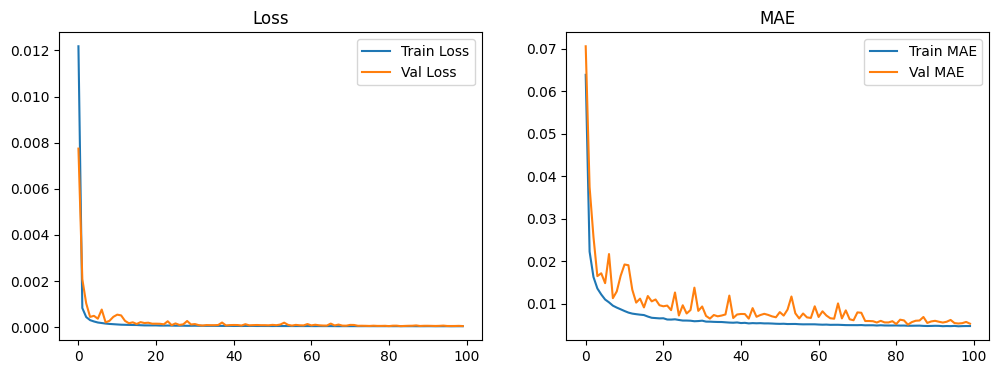

In [10]:
import matplotlib.pyplot as plt

# 훈련 손실 및 MAE 시각화
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.title('MAE')

plt.show()

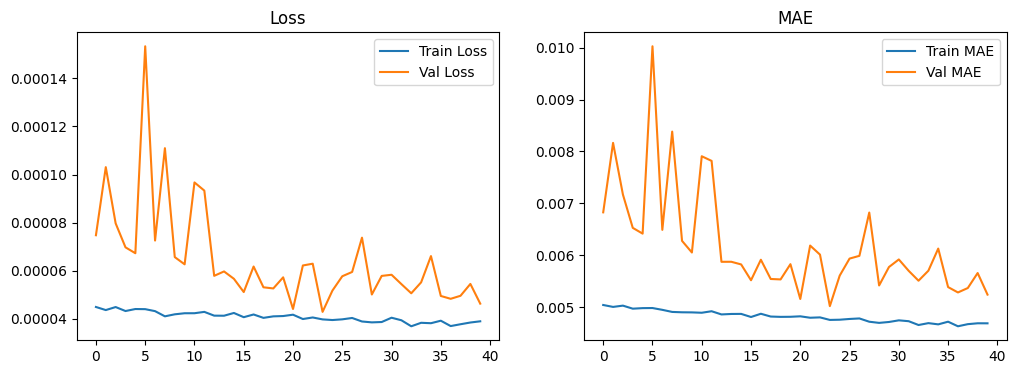

In [11]:
import matplotlib.pyplot as plt

# 훈련 손실 및 MAE 시각화
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'][60:], label='Train Loss')
plt.plot(history.history['val_loss'][60:], label='Val Loss')
plt.legend()
plt.title('Loss')

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'][60:], label='Train MAE')
plt.plot(history.history['val_mae'][60:], label='Val MAE')
plt.legend()
plt.title('MAE')

plt.show()

In [11]:
import tensorflow as tf

model = tf.keras.models.load_model('model_h5/y_all_v2_adam.h5')

2024-11-18 07:57:36.638724: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:746] failed to allocate 9.96MiB (10446336 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-11-18 07:57:36.639687: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:746] failed to allocate 9.96MiB (10446336 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-11-18 07:57:46.640997: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:746] failed to allocate 9.96MiB (10446336 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-11-18 07:57:46.641965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:746] failed to allocate 9.96MiB (10446336 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-11-18 07:57:46.641986: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 600.0KiB (rounded to 614400)requested by op AddV2
If the cause is memory fragmentation maybe the

ResourceExhaustedError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2] name: 

In [10]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
import time
from tensorflow.keras import layers, models

# 분산 전략 내에서 모델 정의 및 컴파일
with strategy.scope():
    model = model
    # 4. 모델 컴파일
    # 옵티마이저, 손실 함수, 평가 지표를 정의합니다.
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
        loss='mse',
        metrics=['mae']
    )
    
    # 5. 콜백 설정
    checkpoint = ModelCheckpoint('v2_rmsprop_all_5.h5', monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=1)
    csv_logger = CSVLogger('v2_rmsprop_all_5.csv', append=True)
    
    # 6. 모델 훈련
    EPOCHS = 50
    
    history = model.fit(
        train_ds, 
        epochs=EPOCHS,
        validation_data=val_ds,
        callbacks=[checkpoint, reduce_lr, csv_logger]
    )

ValueError: Variable (<tf.Variable 'Conv1/kernel:0' shape=(3, 3, 3, 32) dtype=float32, numpy=
array([[[[-1.62003890e-01, -3.43398064e-01,  1.99517068e-02,
          -5.93232973e-21,  1.78276837e-01, -1.33726284e-01,
          -1.46506191e-03, -3.10708203e-22, -9.50230379e-03,
           1.97796777e-01, -3.15664560e-01,  3.95997976e-22,
          -2.36236629e-22,  3.36706383e-22,  6.66153952e-02,
          -6.56183958e-02, -1.37146618e-02, -3.86021957e-02,
           5.35075180e-02,  5.53736472e-21, -1.58215519e-02,
          -1.51424691e-01, -1.36073619e-01,  1.21335825e-02,
          -2.65372515e-01,  4.58397670e-03, -1.26510556e-03,
          -1.10923037e-01,  5.55126644e-22, -1.64047442e-02,
           2.64920771e-01,  7.95240626e-02],
         [-3.10974061e-01, -6.22933388e-01, -1.79552272e-01,
          -6.76705635e-21, -5.89643359e-01, -2.71996856e-01,
          -5.62466159e-02,  1.32427304e-22, -1.43495053e-02,
           3.50541800e-01, -4.83985603e-01,  3.63034420e-22,
           1.64733595e-22,  1.97648923e-22,  1.34229362e-01,
          -1.05439141e-01,  9.02604603e-04, -5.33998609e-02,
          -2.13451296e-01,  3.16011650e-21,  7.40648955e-02,
           5.19171543e-02, -2.90288776e-01,  4.21962643e-04,
          -3.50944757e-01,  3.40309925e-02, -1.53219642e-03,
          -1.84690416e-01, -1.61162945e-22, -8.13668128e-03,
           4.96390700e-01,  2.28244942e-02],
         [-9.12254006e-02, -1.91295460e-01,  9.46527645e-02,
          -8.81519674e-22,  3.89205784e-01, -6.75834343e-02,
           5.78312986e-02,  1.86135438e-23,  2.46351846e-02,
           8.21920931e-02, -1.47660002e-01,  3.51591948e-22,
           4.44115563e-22,  8.28426129e-23, -4.73476760e-03,
          -6.70849998e-03, -7.16123468e-05, -3.20509672e-02,
          -3.73813421e-01,  4.24975389e-21, -6.87392130e-02,
           3.09489127e-02, -8.60727429e-02,  9.02025029e-02,
          -1.46167174e-01,  5.03610063e-04, -1.68796733e-03,
          -6.83206916e-02, -4.44417880e-22,  1.06473733e-03,
           1.87266573e-01, -3.17921601e-02]],

        [[-2.75402963e-01,  3.47477943e-01, -1.46307424e-01,
          -4.61353767e-21,  1.08363308e-01, -3.10072806e-02,
          -7.60274976e-02, -4.43750592e-22,  7.37755448e-02,
           3.19586307e-01,  4.59411107e-02,  3.35785776e-22,
           2.05983384e-22,  1.89247567e-22,  2.11788695e-02,
           1.49508312e-01, -1.79097690e-02, -1.07753120e-01,
          -5.88832945e-02,  3.90697840e-21, -6.16875812e-02,
          -5.19600332e-01,  2.66127586e-01,  6.74599409e-02,
          -2.55393982e-01,  1.87300239e-02, -1.25200918e-03,
           3.88996512e-01,  6.68873470e-22, -6.09058402e-02,
           5.87684587e-02,  5.47657348e-03],
         [-4.61095482e-01,  6.35236442e-01,  6.67730765e-03,
          -5.16069543e-21, -5.45725942e-01, -4.25851531e-02,
          -9.74820331e-02, -2.57652877e-22,  1.72997817e-01,
           5.35732627e-01, -4.27971259e-02,  2.41477189e-22,
           5.13344027e-22,  3.16681407e-22,  2.81869054e-01,
           2.14620650e-01, -2.43428443e-03, -2.12165862e-01,
          -6.01961054e-02,  1.58240941e-22,  6.08968474e-02,
           4.08711970e-01,  3.78205985e-01, -1.23872394e-02,
          -3.61932486e-01,  5.82768358e-02, -1.52471289e-03,
           6.91455543e-01, -1.08337802e-22, -7.75073096e-03,
           2.41111522e-03,  1.55341521e-01],
         [-1.06506273e-01,  2.17945784e-01,  1.06655501e-01,
           6.33635041e-22,  4.45164531e-01, -2.89520342e-03,
          -3.15295570e-02, -3.04778746e-22,  5.63686453e-02,
           1.32970691e-01,  3.35332677e-02,  2.71163250e-22,
           4.81404526e-22,  3.10725015e-22,  1.33521361e-02,
           4.19843979e-02, -2.51814700e-03, -6.08584322e-02,
          -3.08646947e-01,  2.91914926e-21, -1.70365740e-02,
           1.26161411e-01,  5.82138300e-02,  1.74267992e-01,
          -1.23872824e-01, -7.11918855e-03, -1.68052770e-03,
           2.53451854e-01, -4.02265066e-22,  6.70539290e-02,
          -4.52843159e-02,  5.16360402e-02]],

        [[-6.53153583e-02, -5.76538183e-02, -1.87074572e-01,
          -3.46754759e-21, -6.54376298e-02, -2.47746706e-02,
          -6.37388369e-03,  1.25174631e-22, -4.91037853e-02,
           1.46519452e-01,  9.49445292e-02,  3.21970007e-22,
           5.30186725e-22, -1.40879198e-22,  1.91019066e-02,
           2.03975029e-02, -1.62445866e-02,  1.23340696e-01,
          -7.17004389e-03,  7.01061015e-22, -8.20057988e-02,
          -4.32635814e-01, -1.81848288e-01,  1.30204022e-01,
          -4.14933152e-02,  1.04186945e-02, -1.26112846e-03,
          -2.82789230e-01,  4.92878476e-22,  1.32650912e-01,
          -6.22108877e-02, -1.60989359e-01],
         [-1.06637046e-01, -9.27304029e-02,  7.38878027e-02,
          -3.85997249e-21, -3.80072580e-03,  4.95728804e-04,
           1.17617520e-02,  7.60947535e-23, -9.38802734e-02,
           2.09622294e-01, -3.73438038e-02,  1.51740866e-22,
           6.90820363e-22,  3.41281321e-22,  2.71876991e-01,
           1.04293553e-02, -7.16347189e-04,  2.46120349e-01,
           2.25680754e-01, -4.07146699e-21,  5.38825467e-02,
           3.02820414e-01, -1.42560840e-01, -8.10348522e-03,
          -8.52775667e-03,  4.03566137e-02, -1.50224683e-03,
          -4.71863061e-01, -1.77089034e-23, -1.69380262e-01,
          -8.58054981e-02,  6.15613610e-02],
         [-5.87858073e-02, -3.33100744e-02,  4.81078252e-02,
           1.01598721e-21,  4.11290713e-02,  2.14362089e-02,
           4.42955568e-02,  1.13053386e-22, -5.61864674e-03,
           5.35551682e-02,  9.94750764e-03,  2.44916244e-22,
           8.29260933e-22,  4.30840132e-22,  2.92092729e-02,
          -7.47247972e-03, -1.35933247e-03,  6.03593811e-02,
          -2.69497901e-01,  9.32158738e-22,  2.22522169e-02,
           1.50217757e-01,  9.25364159e-03,  2.60004997e-01,
          -4.04795334e-02,  1.56640832e-04, -1.65450503e-03,
          -1.87421635e-01, -2.97987398e-22,  2.82217991e-02,
          -2.20266338e-02,  4.47596572e-02]]],


       [[[ 2.92534828e-01, -4.59971726e-01,  8.65779743e-02,
          -6.75641286e-21,  1.09171003e-01, -3.27847332e-01,
          -3.48242186e-02, -5.95099956e-22,  1.77940264e-01,
          -1.93499550e-01,  3.39907594e-02,  5.38772056e-22,
          -2.10281966e-23,  5.45086376e-22,  4.20326330e-02,
          -1.54816285e-01, -1.49703231e-02, -6.12388030e-02,
          -1.59259210e-03,  7.88645871e-21, -3.82038839e-02,
          -4.32687253e-01,  8.43124539e-02, -5.86650930e-02,
          -1.57893002e-01, -1.53721109e-01, -1.28180510e-03,
           2.27510631e-02,  3.40634683e-22, -4.85908687e-01,
          -3.44701372e-02,  1.76520705e-01],
         [ 5.23387551e-01, -7.64586627e-01, -1.11974016e-01,
          -7.48817609e-21, -4.85469609e-01, -5.18993556e-01,
          -7.50273615e-02, -5.89509721e-22,  2.78298765e-01,
          -3.39447886e-01, -5.38158007e-02,  4.21490123e-22,
           4.70657943e-22,  4.22498300e-22,  1.29547432e-01,
          -2.44773045e-01, -6.20754901e-04, -6.78714067e-02,
          -8.47968310e-02,  5.67678949e-21,  5.05056754e-02,
           2.91181266e-01,  4.17194813e-01,  1.59959402e-02,
          -1.56862661e-01, -2.99161345e-01, -1.54838525e-03,
           1.89893506e-02, -1.88705424e-22,  2.30497047e-01,
          -2.47938588e-04, -9.94349867e-02],
         [ 1.66533872e-01, -1.90436065e-01, -1.90216787e-02,
          -2.64173922e-21,  3.89620006e-01, -1.35791898e-01,
          -3.79666798e-02, -4.98238388e-22,  7.42874369e-02,
          -8.89162719e-02, -2.73494888e-02,  5.27507526e-22,
           2.87445212e-22,  2.83338819e-22,  2.38961764e-02,
          -7.06285536e-02, -1.37640897e-03, -3.84223685e-02,
          -2.58110315e-01,  3.97605162e-21, -4.91721593e-02,
           1.05626523e-01,  1.34677857e-01, -4.29215841e-02,
          -7.71299601e-02, -7.90731460e-02, -1.70946983e-03,
           3.44101936e-02, -5.15508156e-22,  2.06159383e-01,
           4.97893766e-02, -3.52926366e-02]],

        [[ 4.02428180e-01,  3.91904235e-01, -1.30331337e-01,
          -5.17903396e-21,  1.11101329e-01,  4.84935241e-03,
          -2.69033134e-01, -1.07139418e-21,  2.09558636e-01,
          -2.33991355e-01,  4.58865389e-02,  4.31771064e-22,
          -2.59537348e-24,  7.22557260e-22,  2.33176708e-01,
           3.04333866e-01, -2.02539377e-02, -1.42165139e-01,
          -6.86799735e-02,  5.94595277e-21, -7.75119066e-02,
          -6.18550539e-01, -2.54053652e-01, -2.09086183e-02,
          -1.31687477e-01, -5.09836851e-03, -1.27415534e-03,
           4.50751990e-01,  4.97331640e-22, -4.69760925e-01,
           1.47588877e-03,  7.06143379e-02],
         [ 7.03045845e-01,  6.65844142e-01,  9.01686698e-02,
          -5.28414082e-21, -6.02104843e-01,  1.82804726e-02,
          -2.53102064e-01, -1.00353275e-21,  3.54895562e-01,
          -4.47233737e-01, -4.47501540e-02,  3.22428985e-22,
           1.40751971e-22,  8.04534271e-22,  4.08979088e-01,
           5.32129347e-01, -4.65821289e-03, -2.98415929e-01,
          -1.39562100e-01,  1.95102584e-21,  4.15920950e-02,
           4.79838639e-01, -5.39835989e-01, -2.22520204e-03,
          -1.82993442e-01,  2.03608684e-02, -1.55040459e-03,
           7.50413358e-01, -8.45936254e-23,  1.68807775e-01,
          -7.31650069e-02, -1.13795184e-01],
         [ 2.30212927e-01,  1.88120753e-01,  1.28512103e-02,
          -9.39462808e-22,  5.15619695e-01,  1.49640450e-02,
          -2.78915942e-01, -8.48839073e-22,  9.72052962e-02,
          -1.13831311e-01,  1.01259479e-03,  4.71371730e-22,
          -5.93821673e-23,  5.33745813e-22,  1.19979903e-01,
           1.26630202e-01, -4.19358164e-03, -8.71774182e-02,
          -1.91971019e-01,  1.47662614e-21, -2.11576815e-03,
           1.14625469e-01, -1.60260156e-01,  1.38332248e-02,
          -7.48582035e-02, -2.63731629e-02, -1.70748704e-03,
           2.29288116e-01, -3.19080352e-22,  2.99340904e-01,
           2.71347370e-02, -2.89327428e-02]],

        [[ 1.91822976e-01,  1.02274552e-01, -2.54280984e-01,
          -5.37611216e-21,  3.00404429e-02, -2.88207307e-02,
          -3.25133279e-02, -1.92631263e-22,  1.22541606e-01,
          -1.03344493e-01,  3.63750048e-02,  4.64697638e-22,
           6.64051296e-22,  1.00259753e-22,  5.81320301e-02,
          -3.18008699e-02, -1.86126810e-02,  2.20082000e-01,
          -8.05938989e-03,  3.80994301e-21, -1.02011763e-01,
          -1.71976224e-01,  1.73279539e-01,  4.48746160e-02,
           1.62876379e-02, -2.94218324e-02, -1.28299126e-03,
          -4.58351851e-01,  3.23025818e-22, -1.40205503e-01,
          -5.68519086e-02,  2.64080595e-02],
         [ 2.33028203e-01,  1.57950997e-01,  1.65504023e-01,
          -5.05620410e-21, -1.23060435e-01, -6.82704663e-03,
          -2.27466933e-02, -3.70011484e-22,  1.79238111e-01,
          -1.53274119e-01, -4.50509787e-02,  3.95136893e-22,
           1.15517025e-21,  4.35371248e-22,  8.93773586e-02,
          -3.66989896e-02, -3.00873816e-03,  4.13177848e-01,
           8.04219022e-02, -1.71447399e-21,  3.05507705e-02,
           1.34393558e-01,  1.57574922e-01,  1.32539757e-02,
          -3.89129086e-03, -4.10899296e-02, -1.52341265e-03,
          -7.09992409e-01,  6.92674338e-23, -5.69373416e-03,
          -5.05542755e-03, -6.93200901e-03],
         [ 8.18872228e-02,  4.98534366e-02,  3.82551402e-02,
          -1.08841560e-21,  1.00871630e-01,  2.21621580e-02,
          -4.02967297e-02, -4.26323758e-22,  4.84280139e-02,
          -2.47927457e-02,  2.13688873e-02,  4.35426279e-22,
           8.51572141e-22,  2.11475736e-22,  3.06286886e-02,
          -2.01719976e-03, -3.15044564e-03,  1.10509105e-01,
          -1.46200672e-01,  1.25288641e-21,  3.05051412e-02,
           3.70033458e-02,  1.04117217e-02,  1.00657083e-01,
          -2.36836597e-02, -2.98460983e-02, -1.68058602e-03,
          -2.27022827e-01, -2.07820597e-22,  1.41696349e-01,
           4.43275422e-02,  5.46907075e-02]]],


       [[[-1.00282446e-01, -3.91408429e-02,  1.26091108e-01,
          -4.57298562e-21, -1.95974335e-02, -1.94290847e-01,
          -3.36665995e-02,  1.50415422e-23, -1.85374647e-01,
          -1.01187574e-02,  1.07278645e-01,  5.21648094e-22,
           2.66177144e-22,  1.84979161e-22, -6.88081235e-02,
          -1.17135324e-01, -1.46426884e-02, -6.41565695e-02,
           2.43370701e-02,  5.88748426e-21, -1.51694678e-02,
          -2.73925066e-01,  6.71516955e-02, -1.01119854e-01,
          -2.24880725e-02, -3.38270307e-01, -1.26985437e-03,
          -1.57264531e-01,  2.36881980e-22, -4.33491856e-01,
          -7.36863241e-02,  1.52415335e-01],
         [-1.73170686e-01, -2.12081745e-02, -9.18479115e-02,
          -5.48453664e-21, -9.41983014e-02, -2.32436031e-01,
          -2.66419649e-02,  1.17546396e-22, -3.62737268e-01,
           6.32196944e-03, -3.64014618e-02,  4.80906672e-22,
           5.99923392e-22,  1.13800847e-22, -5.68123208e-03,
          -1.61187038e-01, -1.00452069e-03, -6.49154559e-02,
           1.19091079e-01,  3.30852050e-21,  2.37255823e-02,
           1.80883929e-01, -1.26141950e-01,  7.59959817e-02,
          -7.08462810e-03, -4.83448416e-01, -1.55223499e-03,
          -2.67040670e-01, -2.21948755e-22,  1.95624664e-01,
          -1.13174310e-02,  9.45868529e-03],
         [-5.19159473e-02, -2.20508426e-02, -6.78865165e-02,
          -2.11593164e-21,  9.73196477e-02, -5.45452721e-02,
           1.12625686e-02,  1.34313982e-22, -1.19872458e-01,
          -2.17139330e-02, -2.60790791e-02,  4.51941316e-22,
           2.98691062e-22, -4.05920180e-22,  6.08021719e-03,
          -3.67098786e-02, -1.58789370e-03, -3.49768698e-02,
          -1.35651782e-01,  1.16023228e-21, -3.09220720e-02,
           6.57210425e-02, -5.34614809e-02, -1.47579059e-01,
          -1.98249742e-02, -1.55587405e-01, -1.72719092e-03,
          -1.01525083e-01, -5.68250917e-22,  1.86873257e-01,
          -1.79897656e-03, -1.19156197e-01]],

        [[ 4.13699169e-03,  1.32749453e-01, -2.75404379e-02,
          -3.77017008e-21,  5.39139919e-02,  5.85027933e-02,
          -2.60577258e-02, -5.41155653e-22, -3.47137600e-01,
           1.60032441e-03,  9.00506787e-03,  3.75745253e-22,
           6.54014915e-22,  1.01238647e-22, -1.24592474e-02,
           2.33862042e-01, -2.09069233e-02, -7.75884613e-02,
           3.37947011e-02,  4.09139848e-21, -5.72815277e-02,
          -1.55904263e-01, -3.02005168e-02, -6.23147301e-02,
          -1.03613501e-02,  5.81982024e-02, -1.26611302e-03,
           1.71542987e-01,  3.87951999e-22, -3.81903052e-01,
          -1.21963844e-02,  1.34041524e-02],
         [-2.99510267e-02,  1.88543260e-01,  5.03390282e-02,
          -3.72844916e-21, -1.39721334e-01,  8.68826732e-02,
          -7.63744637e-02, -4.66109560e-22, -5.82820177e-01,
           4.11547199e-02, -5.57360388e-02,  2.97017137e-22,
           7.45388081e-22,  1.81958328e-22, -1.61141790e-02,
           3.10875714e-01, -5.46727050e-03, -1.29600480e-01,
           1.27001223e-03,  7.14380420e-22,  1.13728009e-02,
           1.41161650e-01,  1.59502357e-01,  7.65831247e-02,
           1.59177035e-02,  1.21585988e-01, -1.55463396e-03,
           2.12739557e-01, -3.59457989e-22,  1.50312409e-01,
           4.49311100e-02,  5.79387620e-02],
         [ 5.33196097e-03,  7.85858631e-02, -4.99246046e-02,
          -3.11575773e-22,  1.15059212e-01,  3.18704322e-02,
          -2.33438369e-02, -3.71001233e-22, -1.58881858e-01,
          -6.38949266e-03, -2.17928141e-02,  2.96126747e-22,
           3.47260534e-22, -2.49029882e-22, -1.37592303e-02,
           8.39855224e-02, -4.76695132e-03, -4.81447130e-02,
          -5.26269823e-02, -2.44103427e-22,  4.48794290e-03,
          -1.66863333e-02,  9.04082507e-02, -8.57876614e-02,
          -1.66544635e-02,  3.96745317e-02, -1.72745029e-03,
           1.04550064e-01, -6.56476414e-22,  2.35167176e-01,
          -5.32555045e-04,  2.10521109e-02]],

        [[-8.21192488e-02, -1.09360486e-01, -1.70385137e-01,
          -4.00610437e-21,  4.68149856e-02, -9.45684407e-03,
          -1.47218537e-02, -5.56671728e-24, -7.04938322e-02,
          -1.04562705e-02,  1.94787569e-02,  5.00471433e-22,
           3.36557925e-22, -3.20787605e-23, -5.78990625e-03,
          -4.69190441e-02, -1.95777677e-02,  1.50620878e-01,
          -9.60128754e-03,  2.97712218e-21, -9.17426571e-02,
           2.21454144e-01, -4.54436988e-02,  7.52445497e-03,
           2.46561319e-02, -3.02592944e-02, -1.27444626e-03,
          -2.51495037e-02,  4.47330077e-22, -2.53230453e-01,
          -7.20992759e-02, -2.82401107e-02],
         [-1.09376699e-01, -1.89997733e-01,  1.17540024e-01,
          -3.44403232e-21, -8.15738961e-02, -2.21268125e-02,
           2.52050627e-02,  1.30765029e-22, -1.55375019e-01,
          -1.51914535e-02, -6.48970483e-03,  4.26046382e-22,
           8.40068050e-22,  2.60992725e-22,  2.43629161e-02,
          -6.99521527e-02, -4.48130397e-03,  2.09800363e-01,
          -1.77430678e-02, -1.99627843e-21, -1.05314888e-02,
          -1.91227511e-01, -4.71513160e-02,  1.02970749e-01,
           1.50619168e-02, -3.79241295e-02, -1.52748125e-03,
           3.95890698e-02,  4.42674070e-24,  1.00895137e-01,
          -8.40381682e-02,  2.12284736e-02],
         [-4.23511527e-02, -6.83613643e-02,  1.43494783e-02,
          -4.13883485e-22,  7.87905976e-02, -5.31667285e-03,
          -5.51223103e-03,  2.17046432e-22, -6.84657469e-02,
          -7.74370693e-03, -6.45120814e-03,  4.66122182e-22,
           5.14112390e-22, -2.94116426e-22, -1.41993701e-03,
          -3.41201462e-02, -4.14739735e-03,  7.85298645e-02,
           5.59212565e-02,  4.28518685e-22,  2.42060572e-02,
          -4.61703539e-02, -3.85088809e-02, -8.29328783e-03,
           8.28298088e-03, -3.19606103e-02, -1.69551047e-03,
          -2.33105440e-02, -2.09685047e-22,  1.18816778e-01,
          -2.73459498e-02,  4.22497652e-02]]]], dtype=float32)>) was not created in the distribution strategy scope of (<tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7f82682759f0>). It is most likely because some layers, model, or optimizer was being created outside the distribution strategy scope. Try to make sure your code looks similar to the following.
with strategy.scope():
  model=_create_model()
  model.compile(...)